In [119]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [120]:
import networkx as nx
import numpy as np
import pandas as pd
import statistics
import pickle
import os
import itertools

import sys
sys.path.append('../..')

from networkentropy import network_energy as ne
from tqdm import tqdm_notebook as tqdm
from collections import namedtuple, UserDict
from functools import lru_cache
from sklearn.preprocessing import MinMaxScaler

tqdm.monitor_interval = 0

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [121]:
# two helper functions to calculate the Randić energy and the graph energy of an egocentric network 
# with a given radius.

def calculate_randic_energy(graph, radius=1):
    results = { n: ne.get_randic_energy(nx.ego_graph(G=graph, n=n, radius=radius)) for n in graph.nodes }
    return results


def calculate_graph_energy(graph, radius=1):
    results = { n: ne.get_graph_energy(nx.ego_graph(G=graph, n=n, radius=radius)) for n in graph.nodes }
    return results

In [122]:
def normalize_dict(dictionary, target=1.0, invert=False):
    '''
    Normalizes the values in the dictionary so that they sum up to factor
    
    Args: 
        dictionary: dict to be normalized
        factor: value to which all values in the dictionary should sum up to
    
    Tests:
    >>> normalize_dict({0: 10, 1: 30})
    {0: 0.25, 1: 0.75}
    '''
    raw = sum(dictionary.values())
    factor = target/raw
    result = { key: value*factor for key,value in dictionary.items() }
   
    if invert:
        result = { key: 1 - value for key,value in dictionary.items() }
        result = normalize_dict(result, target=target, invert=False)

    return result

In [123]:
def calculate_energy_gradients(g, energies, radius=1):
    if not g.is_directed():
        g = g.to_directed()
    result = {}
    for edge in g.edges:
        node1 = edge[0]
        node2 = edge[1]
        gradient = energies[node2] - energies[node1]
        result[edge] = gradient
    return result

# leaky rectified linear unit
lreLU = lambda x: x if x >= 0 else np.log10(np.abs(x)+1)

X = np.arange(-10, 10, 0.001)
Y = [ lreLU(x) for x in X ]

ACTIVATIONS = {
    'relu': lambda x: x if x > 0 else 0,
    'elu': lambda x: x if x >= 0 else np.log10(np.abs(x)+1),
}

def calculate_gradient_centrality(g, method_name, energies, activation='relu', personalization=None, radius=1, alpha=0.85, max_iter=1000, tol=1.0e-6):
    if not g.is_directed():
        g = g.to_directed()
    gradients = calculate_energy_gradients(g, energies, radius)
    activation_funtion = ACTIVATIONS[activation]
    gradients = {k: activation_funtion(v) for k, v in gradients.items()}
    
    for edge, value in gradients.items():
        g[edge[0]][edge[1]][method_name] = value
    
    return nx.pagerank(g,
                       personalization=personalization,
                       weight=method_name,
                       alpha=alpha,
                       max_iter=max_iter,
                       tol=tol)

def calculate_graph_gradient_centrality(g, radius=1, alpha=0.85, max_iter=1000, tol=1.0e-6):
    return calculate_gradient_centrality(g, 'graph_gradient', calculate_graph_energy(g),
                                         radius=radius, alpha=alpha, max_iter=max_iter, tol=tol)
    
def calculate_randic_gradient_centrality(g, radius=1, alpha=0.85, max_iter=1000, tol=1.0e-6):
    return calculate_gradient_centrality(g, 'randic_gradient', calculate_randic_energy(g),
                                        radius=radius, alpha=alpha, max_iter=max_iter, tol=tol)

def calculate_graph_gradient_centrality_elu(g, radius=1, alpha=0.85, max_iter=1000, tol=1.0e-6):
    return calculate_gradient_centrality(g, 'graph_gradient', calculate_graph_energy(g), activation='elu',
                                         radius=radius, alpha=alpha, max_iter=max_iter, tol=tol)

def calculate_randic_gradient_centrality_elu(g, radius=1, alpha=0.85, max_iter=1000, tol=1.0e-6):
    return calculate_gradient_centrality(g, 'randic_gradient', calculate_randic_energy(g), activation='elu',
                                        radius=radius, alpha=alpha, max_iter=max_iter, tol=tol)

def calculate_graph_gradient_centrality_personalized(g, radius=1, alpha=0.85, max_iter=1000, tol=1.0e-6):
    energies = calculate_graph_energy(g)
    return calculate_gradient_centrality(g, 'graph_gradient', energies, personalization=energies,
                                         radius=radius, alpha=alpha, max_iter=max_iter, tol=tol)

def calculate_randic_gradient_centrality_personalized(g, radius=1, alpha=0.85, max_iter=1000, tol=1.0e-6):
    energies = calculate_randic_energy(g)
    return calculate_gradient_centrality(g, 'graph_gradient', energies, personalization=energies,
                                         radius=radius, alpha=alpha, max_iter=max_iter, tol=tol)
    
def caculate_personalized_pagerank(g, personalization, alpha=0.85, max_iter=1000, tol=1.0e-6):
    return nx.pagerank(g,
                       personalization=personalization,
                       alpha=alpha,
                       max_iter=max_iter,
                       tol=tol)

def calculate_graph_energy_pagerank(g):
    return caculate_personalized_pagerank(g, calculate_graph_energy(g))

def calculate_randic_energy_pagerank(g):
        return caculate_personalized_pagerank(g, calculate_randic_energy(g))

In [124]:
# helper method for drawing networks

def draw_graph(g, node_decorator, title_postfix='', size_factor=1e4):
    values = node_decorator(g).values()
    options = { 
        'node_color': [d for d in list(values)],
        'node_size': [d * size_factor for d in list(values)],
        'cmap': plt.cm.Oranges,
        'edge_color': 'gray',
    }
    plt.figure(figsize=(10, 6))
    plt.title(g.graph['name'] + title_postfix)
    nx.draw(g, **options)
    plt.show()

In [125]:
# there are two implementations of the gini coefficient computation to make sure that there is no error
# in the actual computation. both implementations return very similar estimations up to 1E-16

def gini(X):
    '''
    Compute the Gini coefficient of a distribution
    
    Args:
        X: array-like distribution
        
    Tests:
    >>> gini([0, 0, 0, 1, 1, 1])
    0.5
    >>> gini([1, 1, 1, 1, 1, 1])
    0.0
    >>> gini([1, 1, 1, 1])
    0.0
    >>> gini([0, 0,  0, 1])
    0.75
    >>> gini([0, 0,  1, 1])
    0.5
    '''
    
    X = np.array(X)
    
    # Mean absolute difference
    mad = np.abs(np.subtract.outer(X, X)).mean()
    
    # Relative mean absolute difference
    rmad = mad/np.mean(X)
    
    # Gini coefficient
    g = 0.5 * rmad
    
    return g

In [126]:
def gini2(x, w=None):
    '''
    Compute the Gini coefficient of the distribution
    
    Tests:
    >>> round(gini2([0, 0, 0, 1, 1, 1]), 2)
    0.5
    >>> round(gini2([1, 1, 1, 1, 1, 1]), 2)
    0.0
    >>> round(gini2([0, 0, 0, 0, 1, 1]), 2)
    0.67
    >>> round(gini2([0, 0, 0, 0, 0, 1]), 2)
    0.83
    '''
    
    
    # Array indexing requires reset indexes.
    x = pd.Series(x).reset_index(drop=True)
    
    if w is None:
        w = np.ones_like(x)
    
    w = pd.Series(w).reset_index(drop=True)
    n = x.size
    wxsum = sum(w * x)
    wsum = sum(w)
    sxw = np.argsort(x)
    sx = x[sxw] * w[sxw]
    sw = w[sxw]
    pxi = np.cumsum(sx) / wxsum
    pci = np.cumsum(sw) / wsum
    g = 0.0
    
    for i in np.arange(1, n):
        g = g + pxi.iloc[i] * pci.iloc[i - 1] - pci.iloc[i] * pxi.iloc[i - 1]
    return g

In [127]:
def normalize_dict(dictionary, target=1.0):
    '''
    Normalizes the values in the dictionary so that they sum up to factor
    
    Args: 
        dictionary: dict to be normalized
        factor: value to which all values in the dictionary should sum up to
    
    Tests:
    >>> normalize_dict({0: 10, 1: 30})
    {0: 0.25, 1: 0.75}
    '''
    raw = sum(dictionary.values())
    factor = target/raw
   
    return { key: value*factor for key,value in dictionary.items() }

In [128]:
import doctest
doctest.testmod()

TestResults(failed=0, attempted=10)

In [129]:
def initial_allocation(g, budget, allocations, copy=True):
    '''
    Performs an initial allocation of a given budget of a resource to all vertices of a given network, using provided allocation schemes
    
    Args:
        g: graph to be annotated
        budget: summary budget of allocation
        allocations: dict of allocation schemes
        copy: specifies if the graph g should be copied before modifitations
        
    Returns:
        graph g with node attributes representing allocations
    '''
    
    if copy:
        g = g.copy()

    for name, method in allocations.items():
        initial_values = method(g)
        if initial_values:
            nx.set_node_attributes(g, normalize_dict(initial_values, target=budget), name)

    return g

In [130]:
# definition of a single iteration where each vertex sends resources to a randomly chosen neighbor

def do_turn(graph, allocations):
    '''
    Performs a single iteration of resource exchange
    
    Args:
        graph: input graph
        allocations: list of names of attributes which hold the initial allocation
    '''
    for node in graph.nodes:
        neighbors = list(set(nx.ego_graph(graph, node, radius=1).nodes()).difference([node]))
        
        if len(neighbors) > 0:
            # select a neighbor to trade resources with
            neighbor = np.random.choice(neighbors)

            # select amount to trade
            amount = 0.001

            for allocation in allocations:

                if graph.nodes[node][allocation] > amount:
                    graph.nodes[node][allocation] -= amount
                    graph.nodes[neighbor][allocation] += amount
                
    return

In [131]:
IterationEntry = namedtuple('IterationEntry', ['network','iteration','allocation','inequality_level', 'inequality'])

def run_network(g, budget, allocations, num_iterations):
    '''
    Creates initial allocation and simulates the flow of resources within the network
    
    Args:
        g: input graph
        budget: initial amount of resource to be distributed
        allocations: list of names of attributes which hold the initial allocation
        num_iterations: number of iterations of resource exchange
        
    '''
    result = []
    # helper function which computes the sum of resource allocation
    # for a given vertex' egocentric network
    sum_ego_graph_resource = lambda g, node, resource, radius: sum([g.nodes[n][resource] for n in nx.ego_graph(g, node, radius=radius).nodes])

    graph_name = g.graph['name']
    
    # select the greatest connected component of a network
    g = nx.subgraph(g, max(nx.connected_components(g.to_undirected()), key=len))
    
    g = initial_allocation(g, budget=budget, allocations=allocations)
    
    for i in tqdm(range(num_iterations)):
        do_turn(g, allocations)

        for allocation in allocations:

            vertex_resource_distribution = list(nx.get_node_attributes(g, allocation).values())
            egonet_resource_distribution = [sum_ego_graph_resource(g, n, allocation, 1) for n in g.nodes]

            result.append(IterationEntry(graph_name, i, allocation, 'vertex_distribution', gini2(vertex_resource_distribution)))
            result.append(IterationEntry(graph_name, i, allocation, 'egonet_distribution', gini2(egonet_resource_distribution)))

    return result

In [132]:
def eigenvector(g):
    eigv = np.linalg.eig(nx.to_numpy_array(g))[1][0]
    print(eigv.dtype)
    eigv = eigv.real
#     eigv_mapped = map(lambda v: v if v > 0 else 0, eigv_flatten)
    eigv_2d = eigv.reshape((-1,1))
    eigv_flatten = MinMaxScaler().fit_transform(eigv_2d).flatten()
    return {n: e for n, e in zip(g.nodes(), eigv_flatten)}

In [133]:
def draw_inequality(df, name, title, last_num=None):
    allocations = df['allocation'].unique()
    distribution_idx = df['inequality_level'] == name
    if last_num is None:
        data_df =  df[distribution_idx]
    else:
        effective_last_num = last_num * allocations.size
        data_df = df[distribution_idx][-effective_last_num:]
    sns.lineplot(data=data_df, x='iteration', y='inequality', hue='allocation', hue_order=list(allocations), 
                 palette=['#e41a1c','#377eb8','#4daf4a','#984ea3','#ff7f00','#ffff33','#a65628','#f781bf','#999999'])
    plt.title(title)

def draw_vertex_inequality(df):
    # gini inequality for vertex inequality
    draw_inequality(df, 'vertex_distribution', 'gini inequality for vertex inequality')

def draw_vertex_inequality_last(df, last_n):
    draw_inequality(df, 'vertex_distribution', 'gini inequality for vertex inequality', last_num=last_n)

def draw_egonet_inequality(df):
    # gini inequality for egocentric networks
    draw_inequality(df, 'egonet_distribution', 'gini inequality for egocentric networks')

def draw_egonet_inequality_last(df, last_n):
    draw_inequality(df, 'egonet_distribution', 'gini inequality for egocentric networks', last_num=last_n)

def draw_inequalities(df, last_n=20):
    df.sort_values('iteration', inplace=True)
    draw_vertex_inequality(df)
    plt.show()
    draw_vertex_inequality_last(df, last_n)
    plt.show()
    draw_egonet_inequality(df)
    plt.show()
    draw_egonet_inequality_last(df, last_n)
    plt.show()

In [134]:
# Definision of helper methods for creating networks

class NetworksDict(UserDict):
    '''
    Intercepts __setitem__ method to assign dict key as graph name
    '''
    def __setitem__(self, name, method):
        def wrapper(*args):
            result = method(*args)
            result.graph['name'] = name
            return result
        super(NetworksDict, self).__setitem__(name, wrapper)

In [135]:
# Constants definisions
N = 300
P_ERDOS_RENYI = 0.025
P_HOLME_KIM = 0.1
M_HOLME_KIM = 2
P_WATTS = 0.3
K_K_OUT = 3
K_ALPHA = 1

In [136]:
NETWORKS_GENERATORS = NetworksDict({
    'erdos-renyi': lambda: nx.erdos_renyi_graph(n=N, p=P_ERDOS_RENYI),
    'erdos-renyi-directed': lambda: nx.erdos_renyi_graph(n=N, p=P_ERDOS_RENYI, directed=True),
    'holme-kim': lambda: nx.powerlaw_cluster_graph(n=N, m=M_HOLME_KIM, p=P_HOLME_KIM),
    'watts-strogatz': lambda: nx.watts_strogatz_graph(n=N, k=4, p=P_WATTS),
    'waxman': lambda: nx.waxman_graph(n=N),
    'scale-free': lambda: nx.DiGraph(nx.scale_free_graph(n=N)),
    'k-out': lambda: nx.DiGraph(nx.random_k_out_graph(n=N, k=K_K_OUT, alpha=K_ALPHA, self_loops=False)),
})

In [137]:
ALLOCATIONS = {
    'random': lambda g: { node: np.random.random() for node in g.nodes },
    'constant': lambda g: { node:1 for node in g.nodes },
    'pagerank': nx.pagerank,
    'randic': calculate_randic_energy,
    'graph': calculate_graph_energy,
    'randic_pagerank': calculate_randic_energy_pagerank,
    'graph_pagerank': calculate_graph_energy_pagerank,
    'randic_gradient_elu': calculate_randic_gradient_centrality_elu,
    'graph_gradnient_elu': calculate_graph_gradient_centrality_elu,
    'randic_gradnient_relu': calculate_randic_gradient_centrality, 
    'graph_gradnient_relu': calculate_graph_gradient_centrality,
    'randic_gradnient_personalized': calculate_randic_gradient_centrality_personalized, 
    'graph_gradnient_personalized': calculate_graph_gradient_centrality_personalized,
}

In [138]:
BUDGET = 1
NUM_ITERS = 300
N_REPEATS = 20

In [139]:
synthetic_dfs = []

#### Lading data

In [140]:
RESULTS_PATH = "energy-gradient-allocation/"
if not os.path.exists(RESULTS_PATH):
    os.mkdir(RESULTS_PATH)

In [141]:
def iteration_entry_to_dict(entry, additional_dict):
    d = entry._asdict()
    d.update(additional_dict)
    return d

C:\Users\Tomi\Anaconda3\envs\entropy\lib\site-packages\networkx\drawing\nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


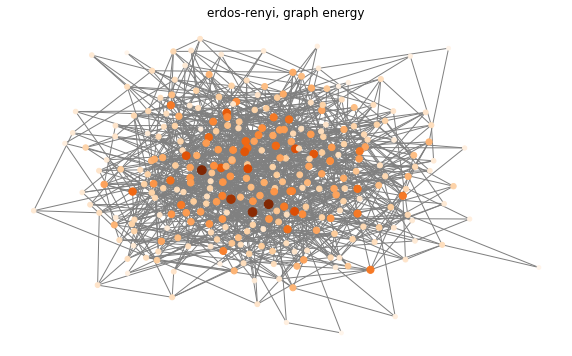

C:\Users\Tomi\Anaconda3\envs\entropy\lib\site-packages\networkx\drawing\nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


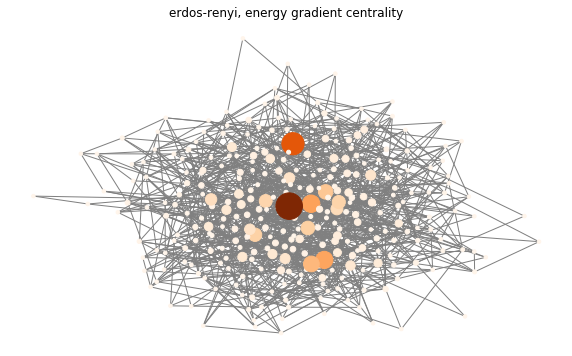

KeyboardInterrupt: 

In [142]:
for network_name, network_creator in tqdm(list(NETWORKS_GENERATORS.items())):
    display(HTML(f'<h2>{network_name}</h2>'))
    g = network_creator()
    draw_graph(g, lambda g: normalize_dict(calculate_graph_energy(g)), title_postfix=', graph energy')
    draw_graph(g, lambda g: normalize_dict(calculate_graph_gradient_centrality(g)), title_postfix=', energy gradient centrality')
    
    dfs = []
    for repeat_no in tqdm(list(range(N_REPEATS))):  
        g = network_creator()
        results = run_network(g, BUDGET, ALLOCATIONS, NUM_ITERS)
        df = pd.DataFrame(list(map(lambda e: iteration_entry_to_dict(e, {'repeat_no': repeat_no}), results)))
        dfs.append(df)
        b
    synthetic_dfs.append(dfs)
        
#     sns.set(rc={'figure.figsize':(11.7,8.27)})    
#     draw_inequalities(df)

/data/anaconda/envs/entropy2/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/data/anaconda/envs/entropy2/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cb.iterable(node_size):  # many node sizes


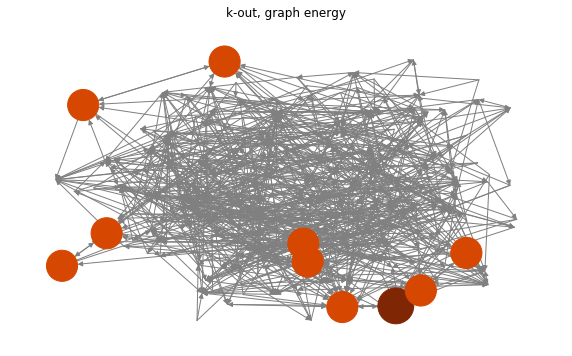

/data/anaconda/envs/entropy2/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/data/anaconda/envs/entropy2/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cb.iterable(node_size):  # many node sizes


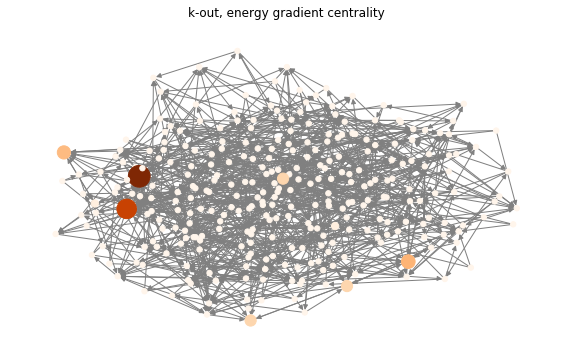

In [26]:
for network_name, network_creator in tqdm(list(NETWORKS_GENERATORS.items())[-1:]):
    display(HTML(f'<h2>{network_name}</h2>'))
    g = network_creator()
    draw_graph(g, lambda g: normalize_dict(calculate_graph_energy(g)), title_postfix=', graph energy')
    draw_graph(g, lambda g: normalize_dict(calculate_graph_gradient_centrality(g)), title_postfix=', energy gradient centrality')
    
    dfs = []
    for repeat_no in tqdm(list(range(N_REPEATS))):  
        g = network_creator()
        results = run_network(g, BUDGET, ALLOCATIONS, NUM_ITERS)
        df = pd.DataFrame(list(map(lambda e: iteration_entry_to_dict(e, {'repeat_no': repeat_no}), results)))
        dfs.append(df)
        
    synthetic_dfs.append(dfs)

#### Saving data

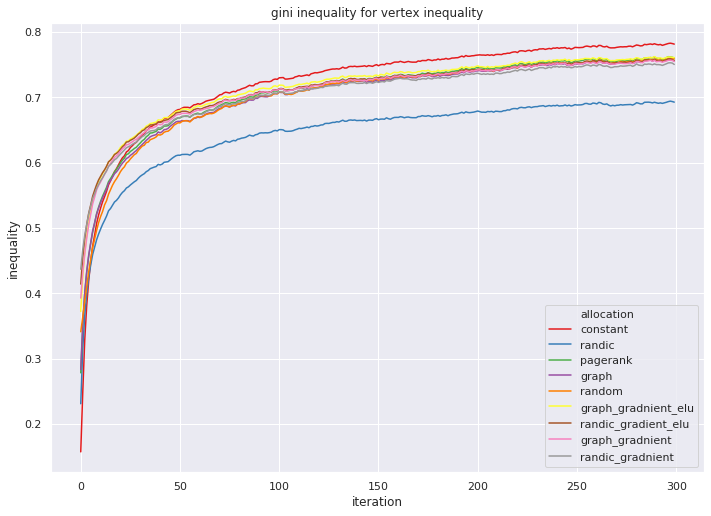

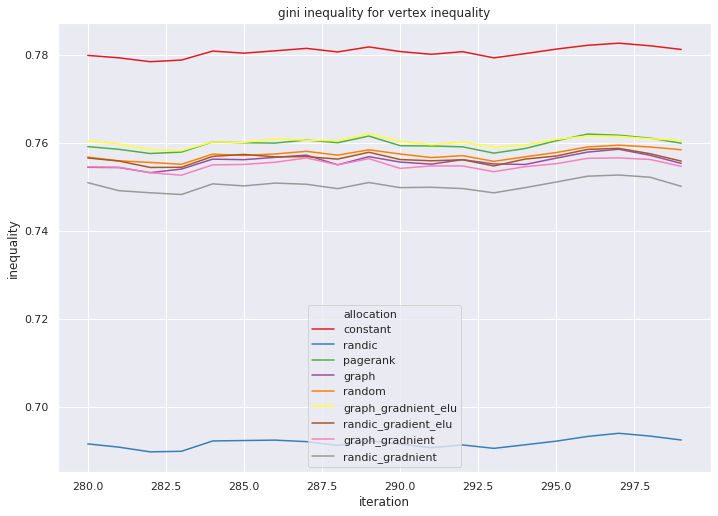

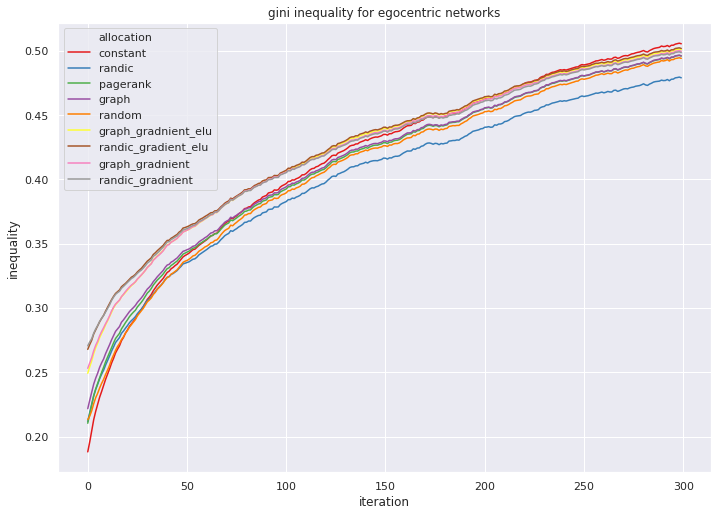

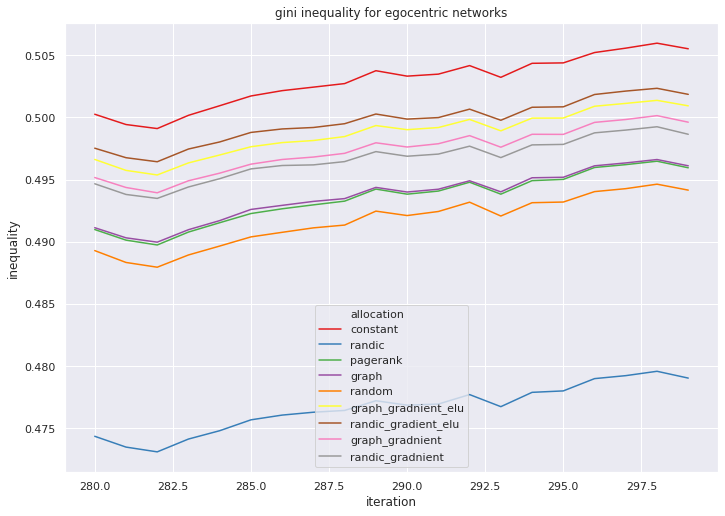

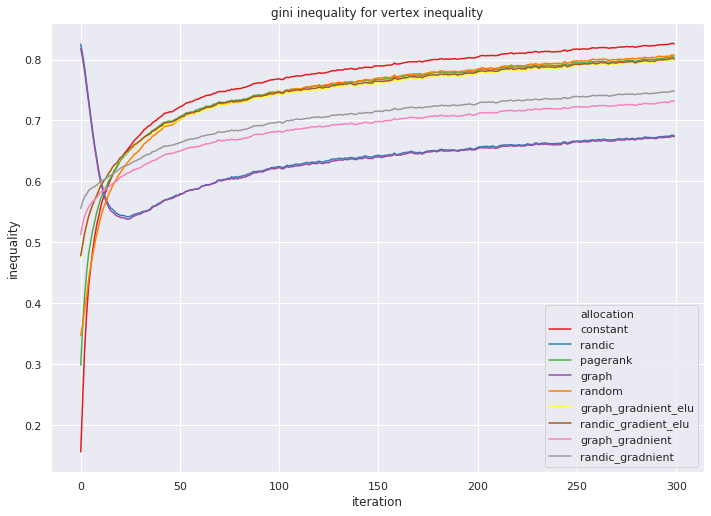

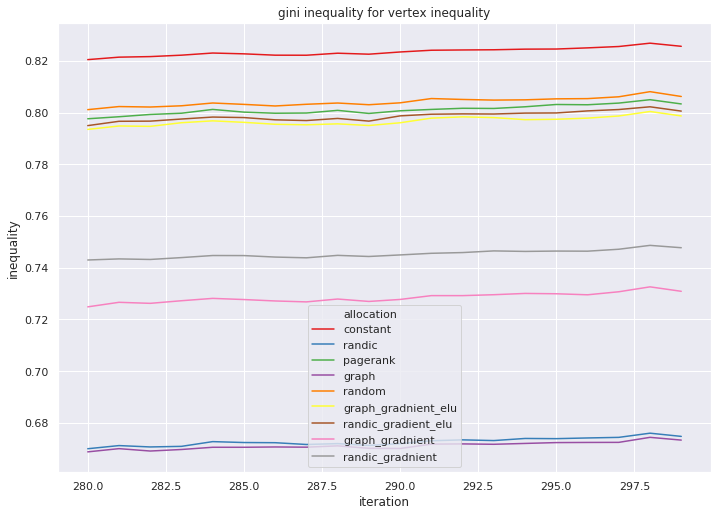

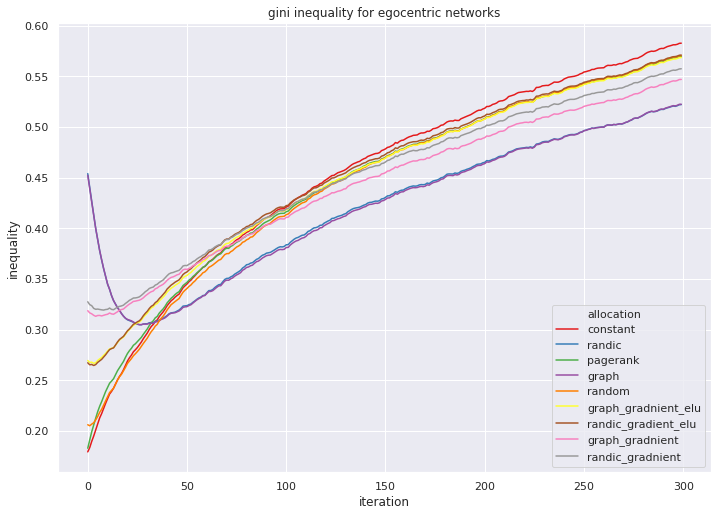

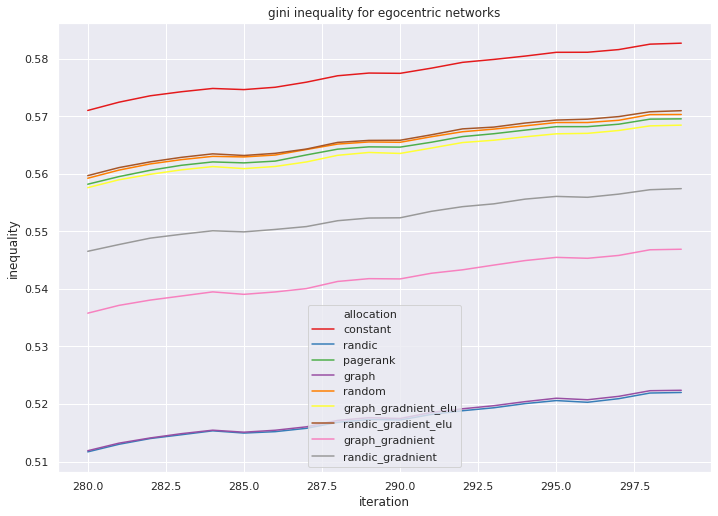

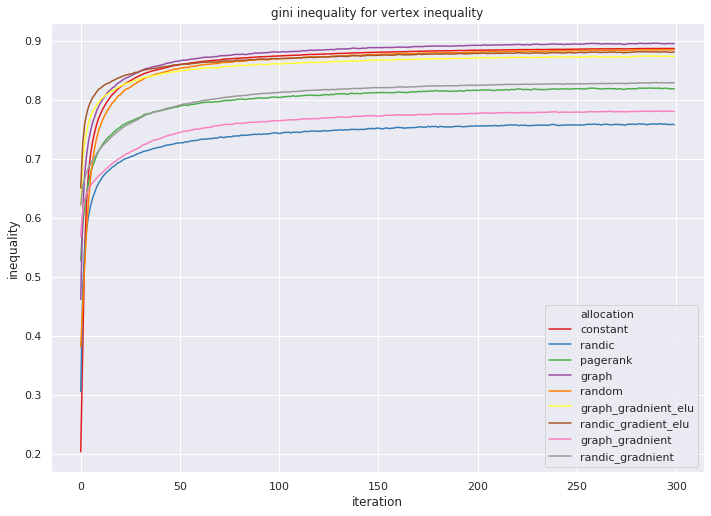

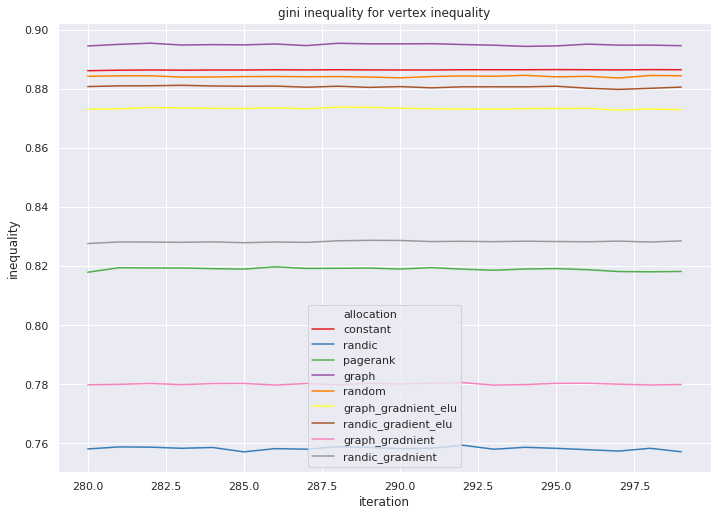

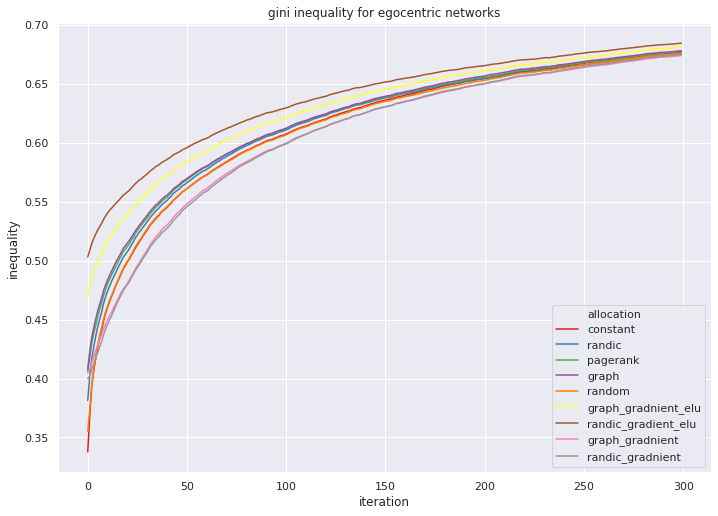

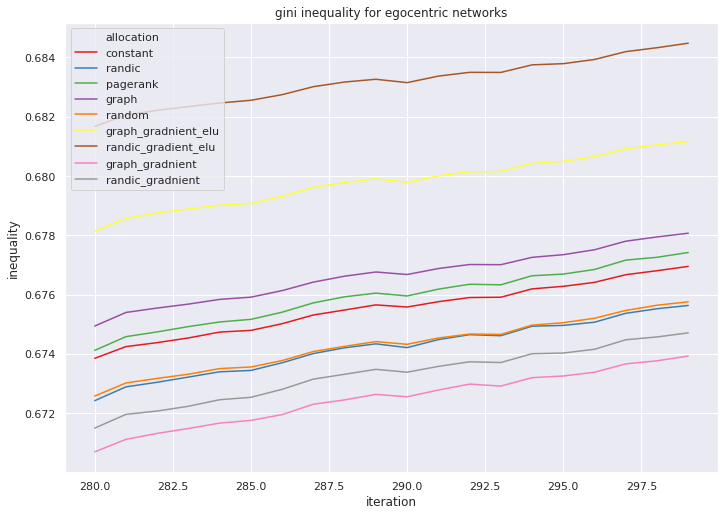

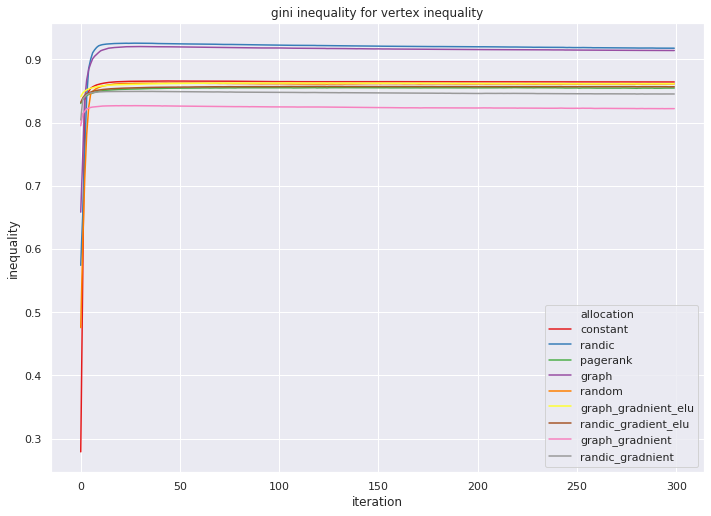

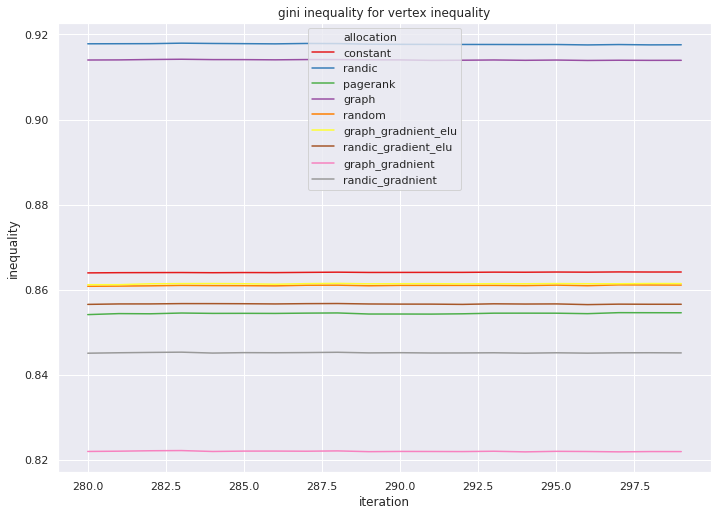

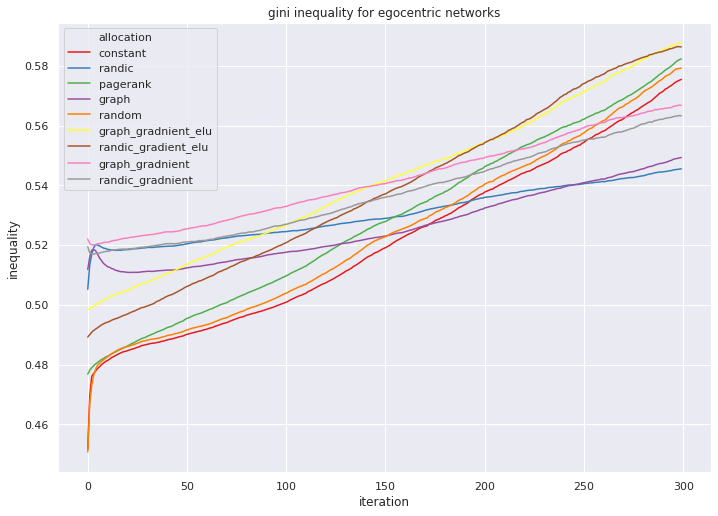

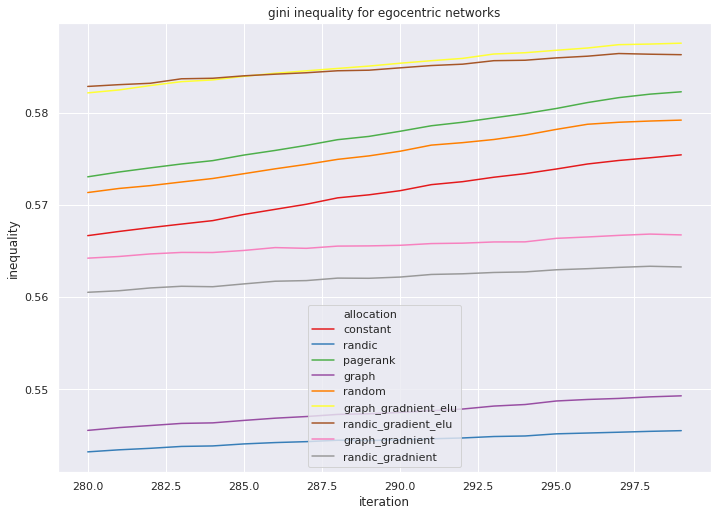

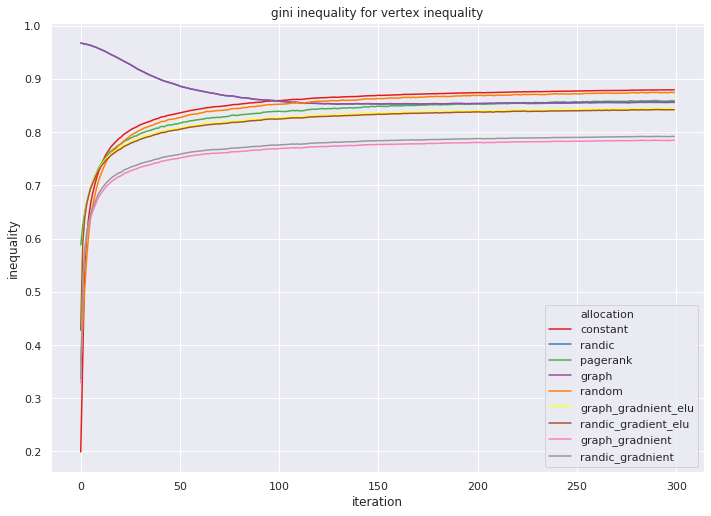

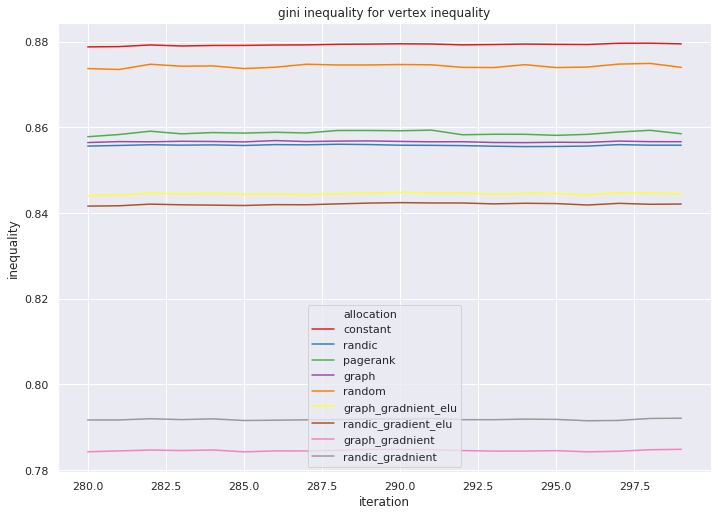

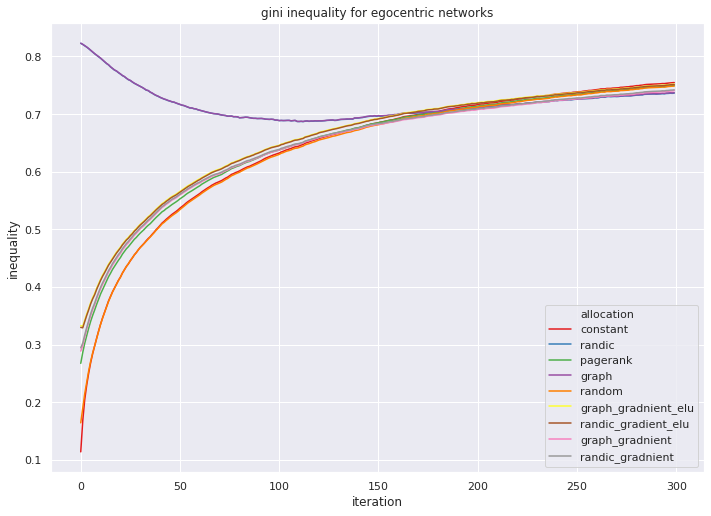

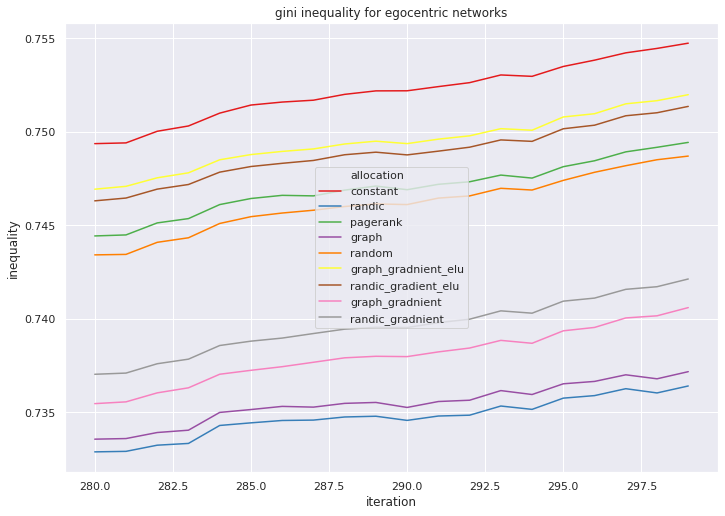

In [180]:
for dfs in synthetic_dfs:
    df = pd.concat(dfs)
    df = df.query("allocation not in ['randic_pagerank', 'graph_pagerank', 'randic_gradnient_personalized', 'graph_gradnient_personalized']")
    avg_df = df.groupby(list(set(df.columns).difference(['repeat_no','inequality']))).mean()
    avg_df.reset_index(inplace=True)
    sns.set()
    sns.set(rc={'figure.figsize':(11.7,8.27)})    
    draw_inequalities(avg_df)

In [26]:
synthetic_df = pd.concat(itertools.chain.from_iterable(synthetic_dfs))

In [27]:
synthetic_avg_df = synthetic_df.groupby(list(set(synthetic_df.columns).difference(['repeat_no', 'inequality']))).mean()
synthetic_avg_df.reset_index(inplace=True)

In [158]:
def get_min_inequlity_method(df, dist):
    idx = df\
    .query("iteration == (@NUM_ITERS - 1) and inequality_level == @dist")\
    .groupby('network')['inequality'].idxmin()
    return df.loc[idx]

In [159]:
def calculate_avg_rate_of_change_and_variance(df):
    result = {
        'avg_roc': [(df.loc[df['iteration'] == NUM_ITERS-1].iloc[0]['inequality'] - df.loc[df['iteration'] == 0].iloc[0]['inequality'])/NUM_ITERS],
        'variance': [statistics.pvariance(df['inequality'])],
    } 
    return pd.DataFrame(result)

def group_and_calculate_avg_roc_and_variance(df):
    return df.groupby(['network', 'allocation', 'inequality_level'])\
.apply(calculate_avg_rate_of_change_and_variance)

In [160]:
def get_min_statistic_method(df, statistic, dist):
    idx = df.query("inequality_level == @dist").groupby('network')[statistic].idxmin()
    return df.loc[idx, statistic].to_frame()

In [183]:
get_min_inequlity_method(synthetic_avg_df, 'vertex_distribution')

network                     allocation  iteration  \
4799            erdos-renyi                         randic        299   
14399  erdos-renyi-directed  randic_gradnient_personalized        299   
20399             holme-kim                         randic        299   
25199                 k-out                graph_gradnient        299   
32999            scale-free                graph_gradnient        299   

          inequality_level  inequality  repeat_no  
4799   vertex_distribution    0.692400        9.5  
14399  vertex_distribution    0.673144        9.5  
20399  vertex_distribution    0.757078        9.5  
25199  vertex_distribution    0.784852        9.5  
32999  vertex_distribution    0.821940        9.5

In [162]:
get_min_inequlity_method(synthetic_avg_df, 'egonet_distribution')

network                    allocation  iteration  \
4798            erdos-renyi                        randic        299   
10798  erdos-renyi-directed  graph_gradnient_personalized        299   
17398             holme-kim               graph_gradnient        299   
28198                 k-out                        randic        299   
35998            scale-free                        randic        299   

          inequality_level  inequality  repeat_no  
4798   egonet_distribution    0.479038        9.5  
10798  egonet_distribution    0.520457        9.5  
17398  egonet_distribution    0.673931        9.5  
28198  egonet_distribution    0.736400        9.5  
35998  egonet_distribution    0.545492        9.5

In [163]:
synthetic_avg_roc_and_variance_df = group_and_calculate_avg_roc_and_variance(synthetic_avg_df)

In [166]:
get_min_statistic_method(synthetic_avg_roc_and_variance_df, 'avg_roc', 'vertex_distribution')

avg_roc
network              allocation                    inequality_level               
erdos-renyi          randic_gradnient_personalized vertex_distribution 0  0.001010
erdos-renyi-directed randic_gradnient_personalized vertex_distribution 0 -0.000646
holme-kim            graph_gradnient_personalized  vertex_distribution 0  0.000457
k-out                randic_gradnient_personalized vertex_distribution 0 -0.000375
scale-free           graph_gradnient_personalized  vertex_distribution 0  0.000065

In [168]:
get_min_statistic_method(synthetic_avg_roc_and_variance_df, 'avg_roc', 'egonet_distribution')

avg_roc
network              allocation                    inequality_level               
erdos-renyi          randic_gradnient_personalized egonet_distribution 0  0.000740
erdos-renyi-directed graph_gradnient_personalized  egonet_distribution 0 -0.000054
holme-kim            graph_gradnient_personalized  egonet_distribution 0  0.000574
k-out                randic_gradnient_personalized egonet_distribution 0 -0.000306
scale-free           graph_gradnient_personalized  egonet_distribution 0  0.000065

In [169]:
get_min_statistic_method(synthetic_avg_roc_and_variance_df, 'variance', 'vertex_distribution')

variance
network              allocation                    inequality_level               
erdos-renyi          randic_gradnient_personalized vertex_distribution 0  0.002664
erdos-renyi-directed graph_gradnient_personalized  vertex_distribution 0  0.001025
holme-kim            randic_gradient_elu           vertex_distribution 0  0.000526
k-out                graph                         vertex_distribution 0  0.000835
scale-free           graph_gradnient_elu           vertex_distribution 0  0.000004

In [170]:
get_min_statistic_method(synthetic_avg_roc_and_variance_df, 'variance', 'egonet_distribution')

variance
network              allocation                    inequality_level               
erdos-renyi          randic_gradnient_personalized egonet_distribution 0  0.003270
erdos-renyi-directed graph_gradnient_personalized  egonet_distribution 0  0.001653
holme-kim            randic_gradient_elu           egonet_distribution 0  0.001754
k-out                graph_gradnient_personalized  egonet_distribution 0  0.000765
scale-free           randic_gradnient_personalized egonet_distribution 0  0.000073

In [39]:
from bs4 import BeautifulSoup
import requests
import wget
import tarfile
import shutil
import time

In [40]:
NAME = 'name'
CATEGORY = 'category'
DIRECTED = 'directed'
NUM_NODES = 'num_nodes'
NUM_EDGES = 'num_edges'

Dataset = namedtuple('Dataset', [NAME, CATEGORY, DIRECTED, NUM_NODES, NUM_EDGES])

@lru_cache(maxsize=100)
def read_avalilable_datasets_konect():
    base_url = "http://konect.uni-koblenz.de/networks/"
    response = requests.get(base_url)
    
    if response.status_code != 200:
        print("An error occurred while getting data.")
    else:
        html = response.content
        soup = BeautifulSoup(html, "html5lib")
        
        table_html = soup.find(id='sort1')
        
        thead_html = table_html.find('thead')
        tbody_html = table_html.find('tbody')
         
        networks = []
        column_names=[row.text for row in thead_html.findAll('td')]
        rows = tbody_html.findAll('tr')
        for row in rows:
            if row:
                tds = row.find_all('td')
                networks.append(Dataset(name=tds[1].a.get('href').replace('/', ''),
                                        category=tds[2].span.text,
                                        directed=tds[3].a.img.get('title').startswith('Directed'),
                                        num_nodes=int(tds[6].text.replace(',', '')),
                                        num_edges=int(tds[7].text.replace(',', ''))
                                       ))
        return pd.DataFrame(list(map(lambda e: e._asdict(), networks)))
        
def download_tsv_dataset_konect(network_name, path_prefix):
    assert (network_name in list(read_avalilable_datasets_konect()[NAME])),"No network named: '"+network_name+"' found in Konect!"
    
    tsv_file = 'http://konect.uni-koblenz.de/downloads/tsv/'+network_name+'.tar.bz2'
    output_file=path_prefix+network_name+'.tar.bz2'
    file_name = wget.download(tsv_file, out=output_file)
    if os.path.exists(output_file):
        shutil.move(file_name,output_file)
    
    return output_file
    
def unpack_tar_bz2_file(file_name, output_dir):
    tar = tarfile.open("./"+file_name, "r:bz2")
    tar.extractall(output_dir)
    tar.close()
    return output_dir

def build_network_from_out_konect(network_name, path_prefix):
    unpacked_dir = f'{path_prefix}network_{network_name}/'
    network_dir=unpacked_dir+network_name+"/"
    if not os.path.exists(unpacked_dir):
        file_name=download_tsv_dataset_konect(network_name=network_name, path_prefix=path_prefix)
        unpack_tar_bz2_file(file_name, unpacked_dir)
    files = [file for file in os.listdir(network_dir) if os.path.isfile(os.path.join(network_dir, file))]
    out_file = [file for file in files if 'out.' in file]
    assert (len(out_file)>0), 'No out. file in the directory.'
    
    #building network
    G=nx.read_adjlist(network_dir+out_file[0], comments='%')
    G.graph['name'] = network_name
    
    return G

In [41]:
networks_names = [
 'moreno_beach',
 'moreno_bison',
 'moreno_blogs',
 'moreno_cattle',
 'moreno_crime',
 'moreno_health',
 'moreno_hens',
 'moreno_highschool',
 'moreno_innovation',
 'moreno_kangaroo',
 'moreno_lesmis',
 'moreno_mac',
 'moreno_names',
 'moreno_oz',
 'moreno_propro',
 'moreno_rhesus',
 'moreno_sampson',
 'moreno_seventh',
 'moreno_sheep',
 'moreno_taro',
 'moreno_train',
 'moreno_vdb',
 'moreno_zebra',
 'brunson_club-membership',
 'brunson_southern-women',
 'brunson_corporate-leadership',
 'brunson_revolution',
 'brunson_south-africa',
 'ucidata-gama',
 'ucidata-zachary',
 'opsahl-collaboration',
 'opsahl-openflights',
 'opsahl-powergrid',
 'opsahl-southernwomen',
 'opsahl-ucforum',
 'opsahl-ucsocial',
 'opsahl-usairport',
 'contiguous-usa',
 'dolphins',
 'adjnoun_adjacency',
 'mit',
 'foodweb-baydry',
 'foodweb-baywet',
 'sociopatterns-hypertext',
 'sociopatterns-infectious',
 'radoslaw_email'
]

In [42]:
networks = []

for network_name in tqdm(networks_names):
    networks.append(build_network_from_out_konect(network_name, path_prefix="networks_download/"))

In [43]:
BUDGET = 1
NUM_ITERS = 300
SMALL_NETWORK_THRESHOLD = 1000

In [44]:
small_networks = [(network_name, network) for (network_name, network) in zip(networks_names, networks) if network.number_of_nodes() < SMALL_NETWORK_THRESHOLD]

In [48]:
empirical_dfs = []

In [49]:
N_REPEATS = 4

/data/anaconda/envs/entropy2/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


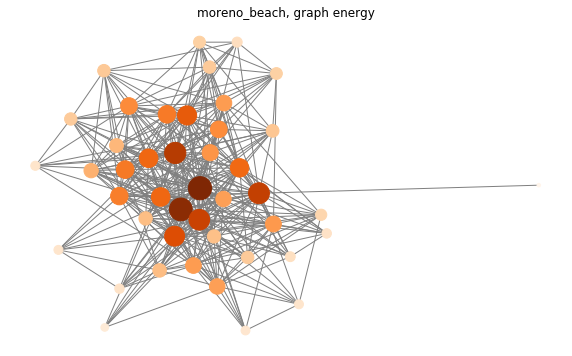

/data/anaconda/envs/entropy2/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


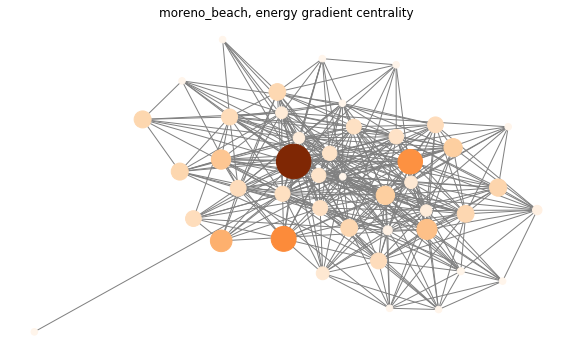

/data/anaconda/envs/entropy2/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


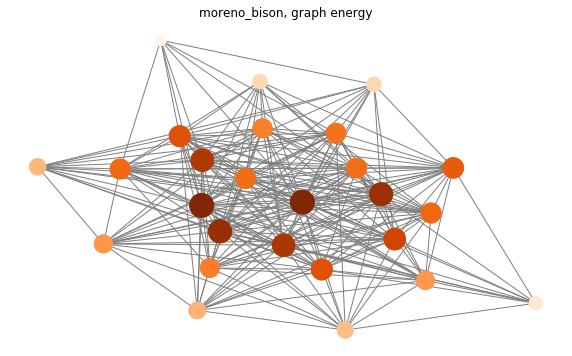

/data/anaconda/envs/entropy2/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


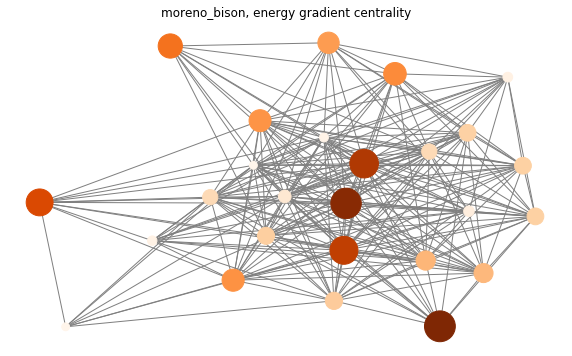

/data/anaconda/envs/entropy2/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


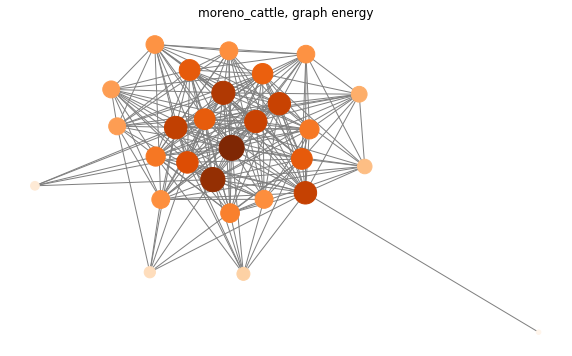

/data/anaconda/envs/entropy2/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


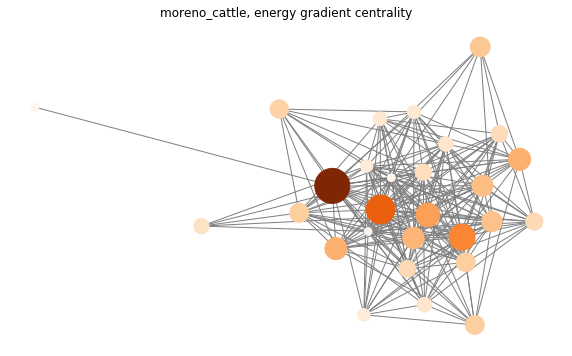

/data/anaconda/envs/entropy2/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


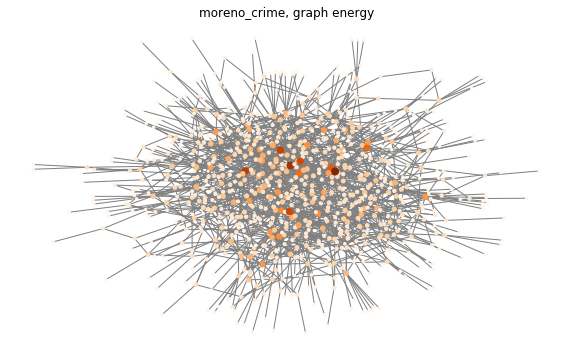

/data/anaconda/envs/entropy2/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


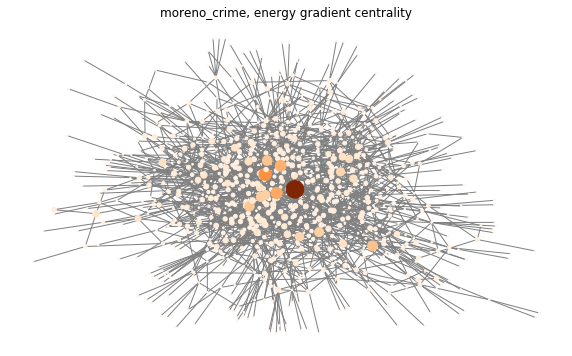

/data/anaconda/envs/entropy2/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


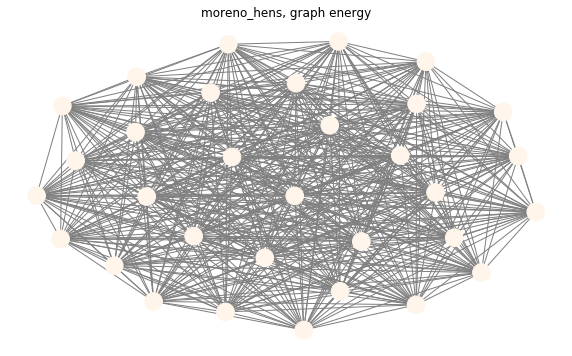

/data/anaconda/envs/entropy2/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


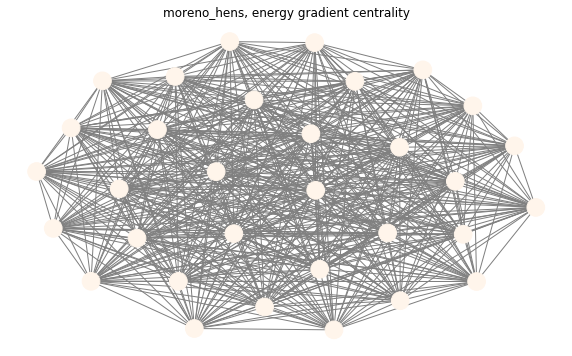

/data/anaconda/envs/entropy2/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


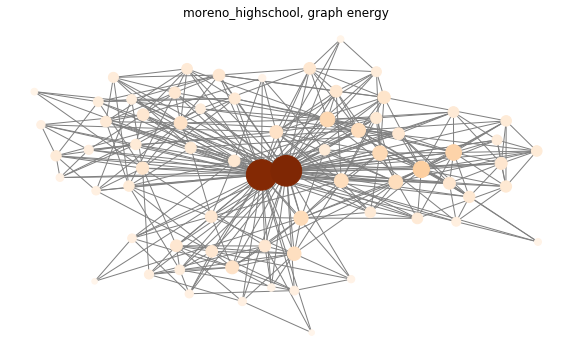

/data/anaconda/envs/entropy2/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


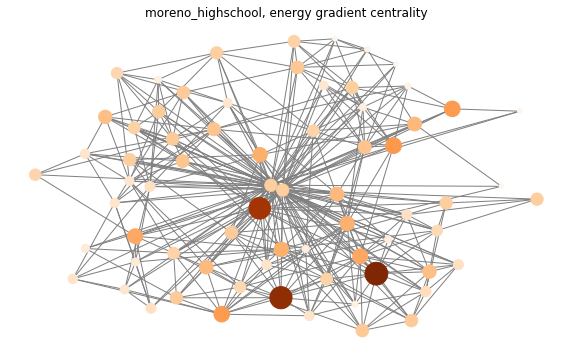

/data/anaconda/envs/entropy2/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


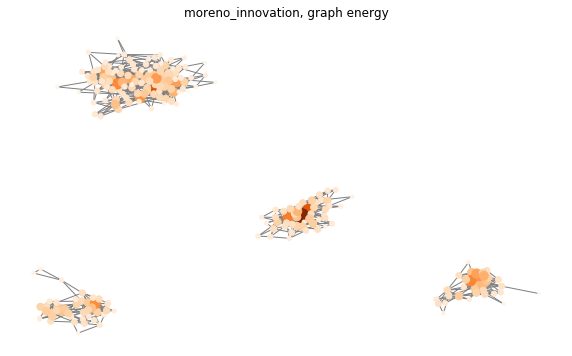

/data/anaconda/envs/entropy2/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


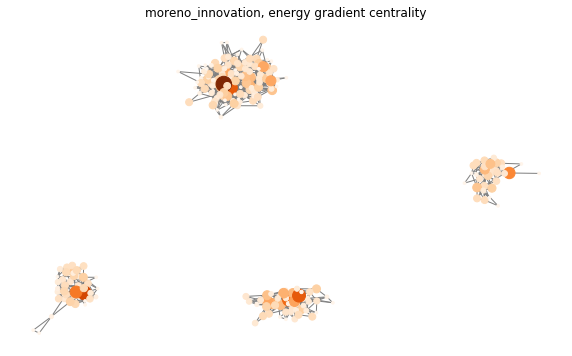

/data/anaconda/envs/entropy2/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


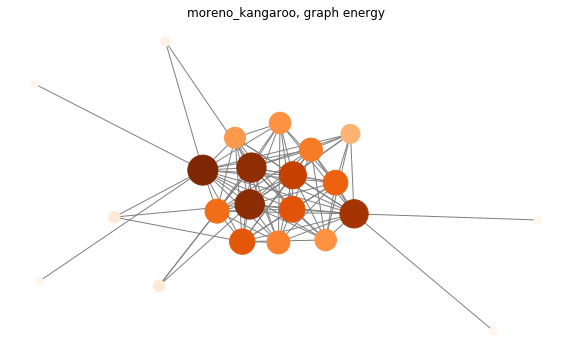

/data/anaconda/envs/entropy2/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


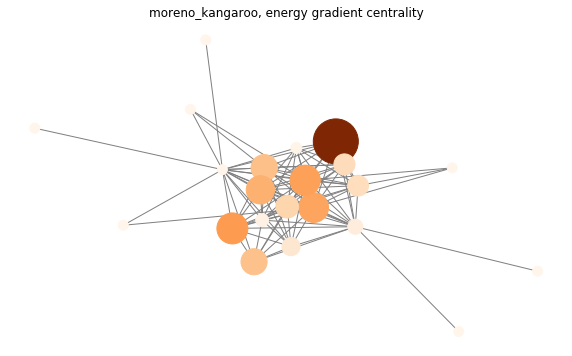

/data/anaconda/envs/entropy2/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


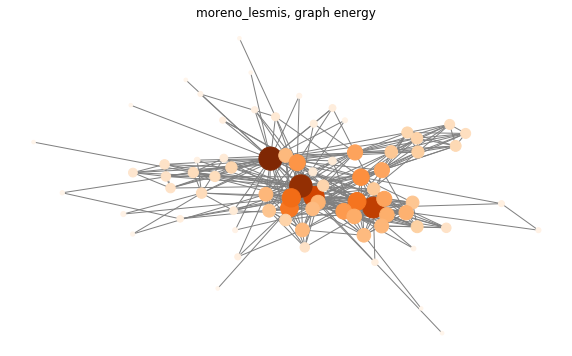

/data/anaconda/envs/entropy2/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


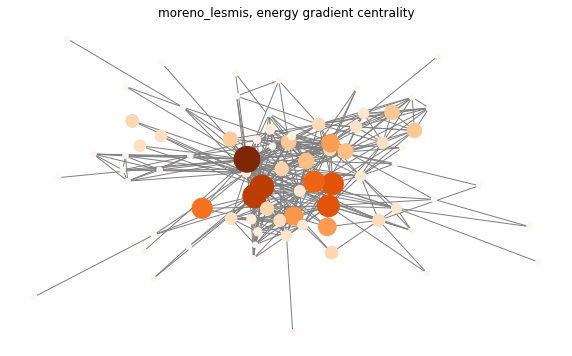

/data/anaconda/envs/entropy2/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


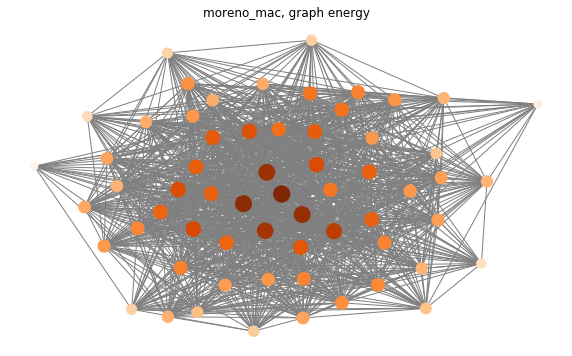

/data/anaconda/envs/entropy2/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


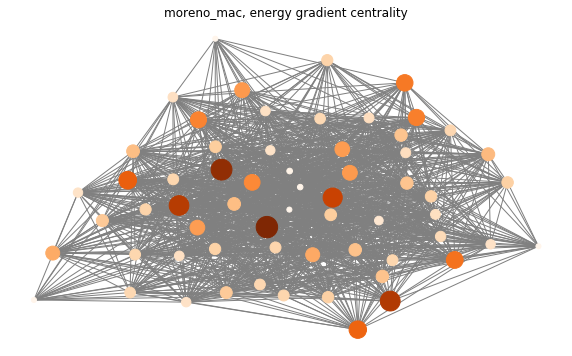

/data/anaconda/envs/entropy2/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


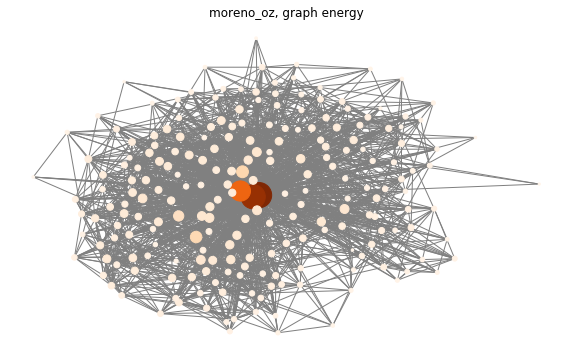

/data/anaconda/envs/entropy2/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


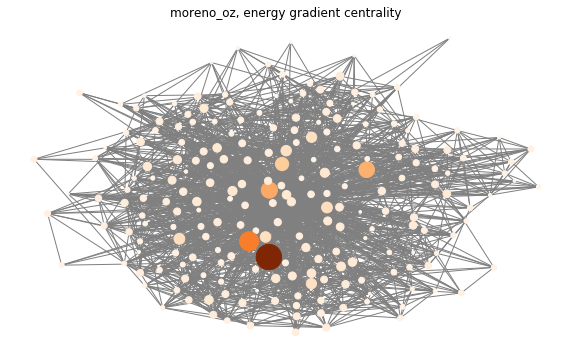

/data/anaconda/envs/entropy2/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


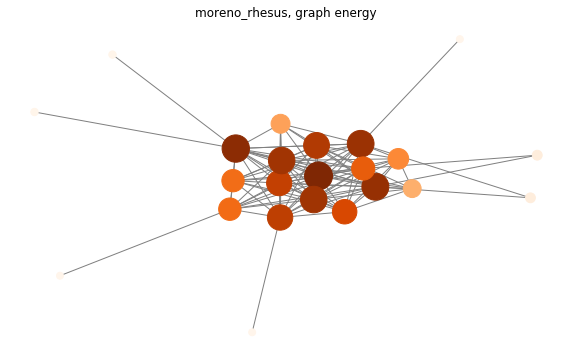

/data/anaconda/envs/entropy2/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


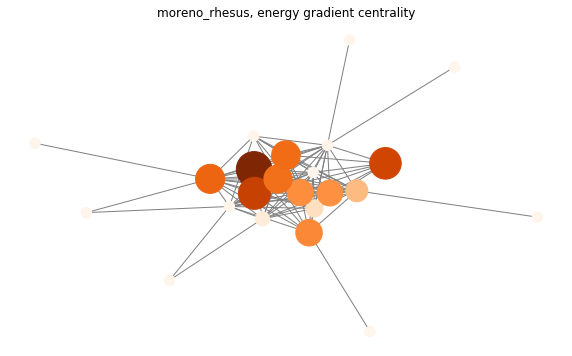

/data/anaconda/envs/entropy2/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


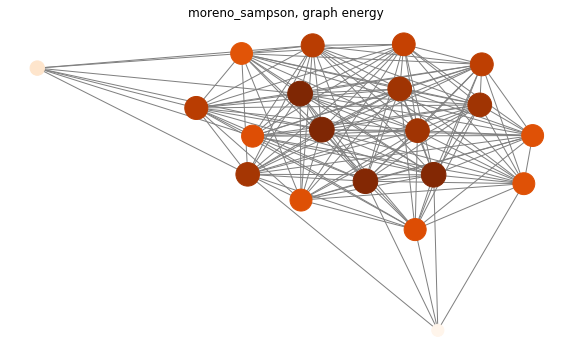

/data/anaconda/envs/entropy2/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


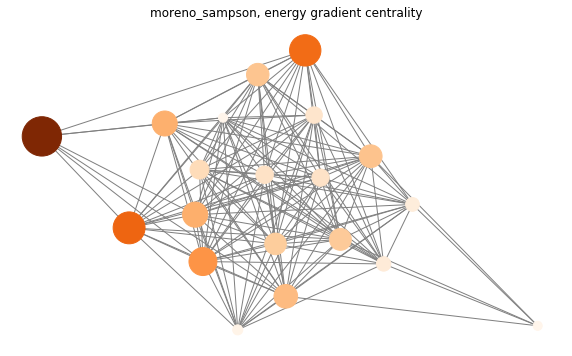

/data/anaconda/envs/entropy2/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


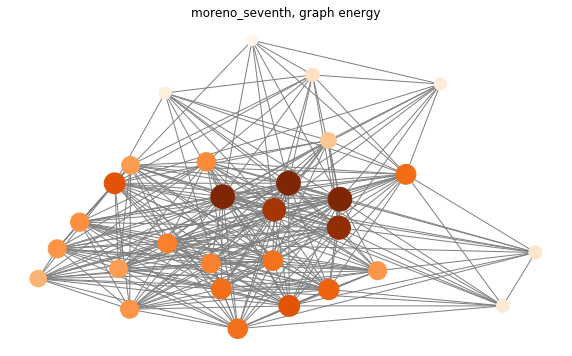

/data/anaconda/envs/entropy2/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


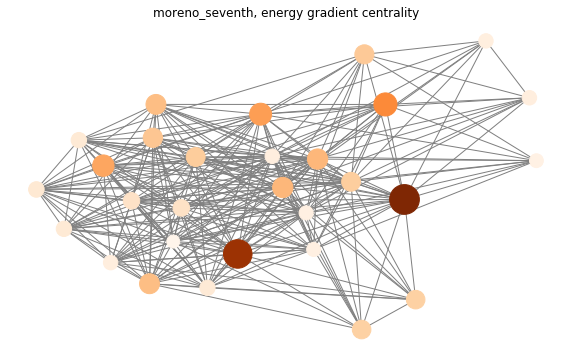

/data/anaconda/envs/entropy2/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


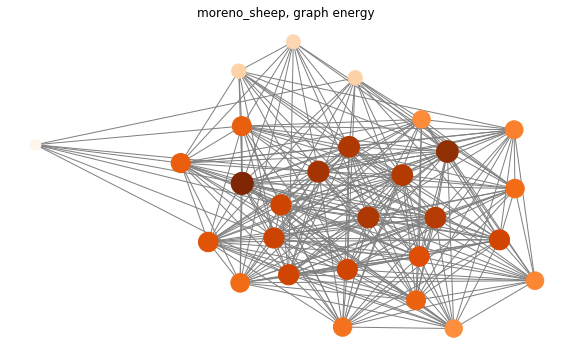

/data/anaconda/envs/entropy2/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


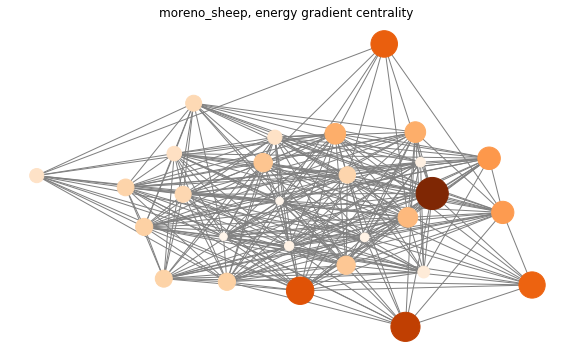

/data/anaconda/envs/entropy2/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


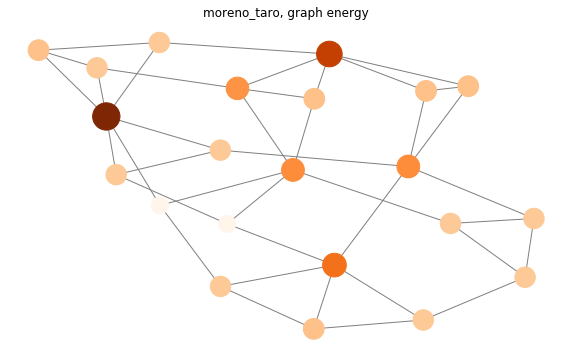

/data/anaconda/envs/entropy2/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


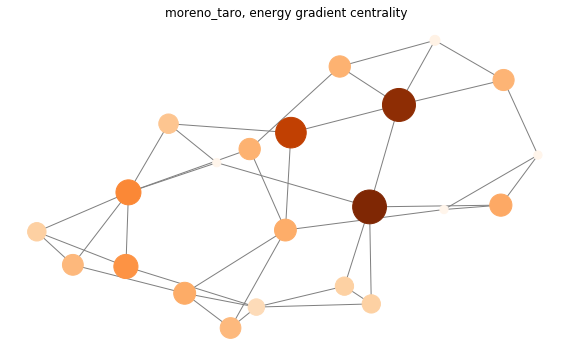

/data/anaconda/envs/entropy2/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


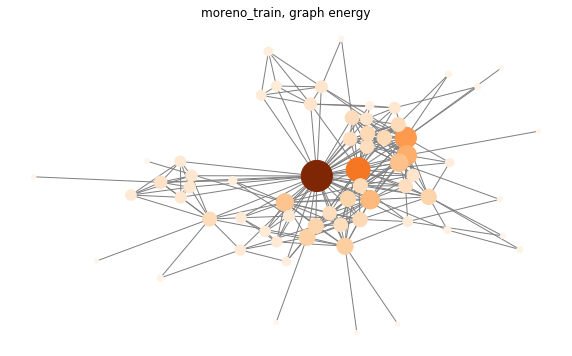

/data/anaconda/envs/entropy2/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


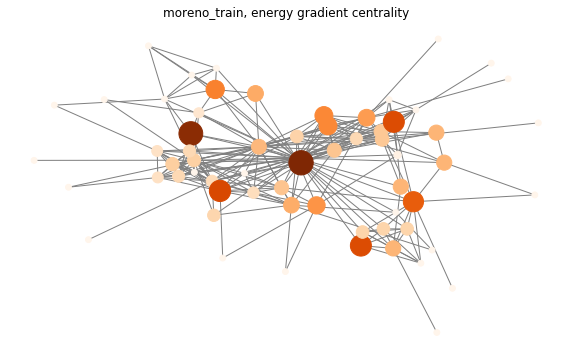

/data/anaconda/envs/entropy2/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


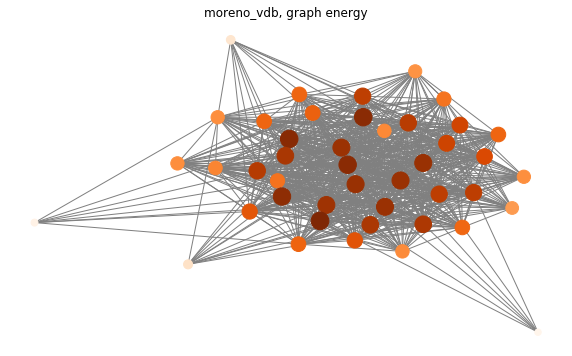

/data/anaconda/envs/entropy2/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


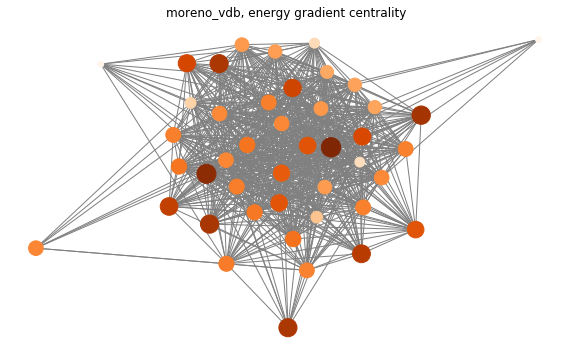

/data/anaconda/envs/entropy2/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


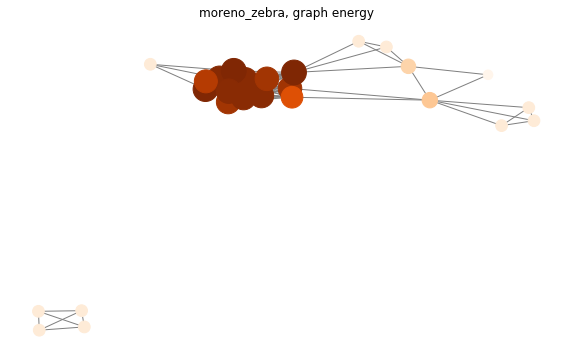

/data/anaconda/envs/entropy2/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


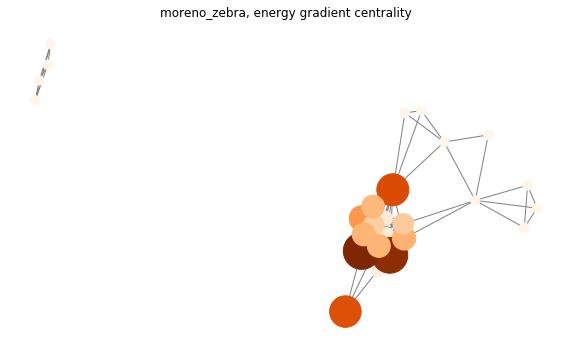

/data/anaconda/envs/entropy2/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


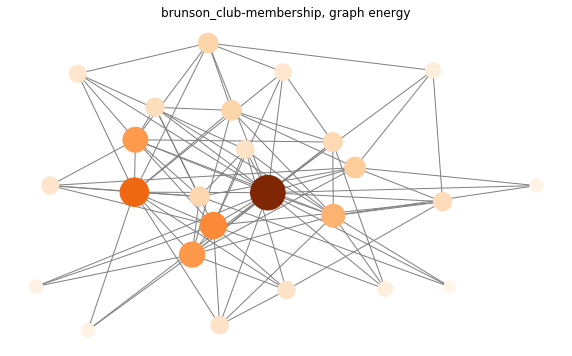

/data/anaconda/envs/entropy2/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


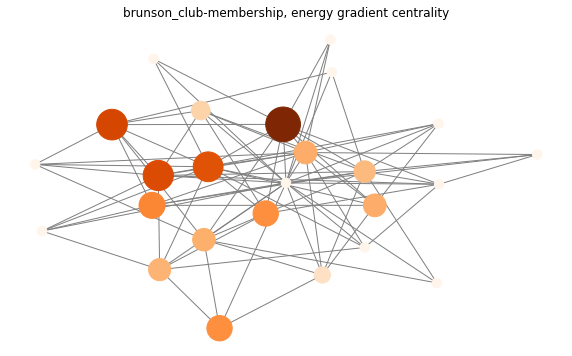

/data/anaconda/envs/entropy2/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


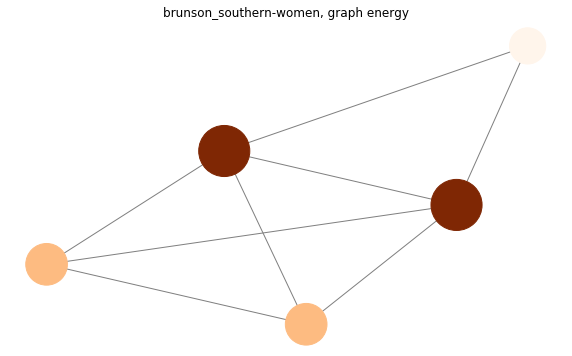

/data/anaconda/envs/entropy2/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


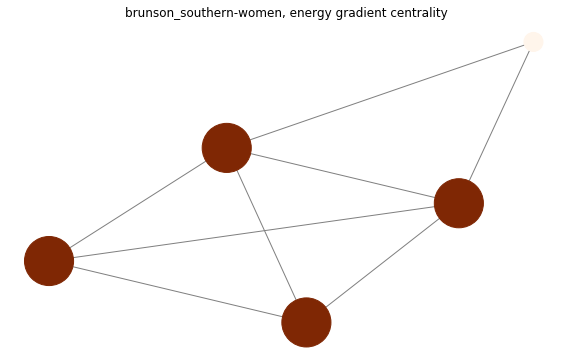

/data/anaconda/envs/entropy2/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


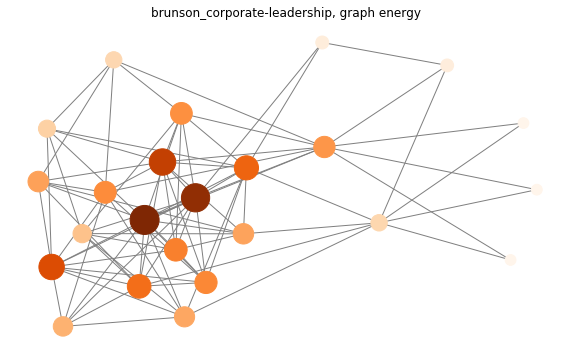

/data/anaconda/envs/entropy2/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


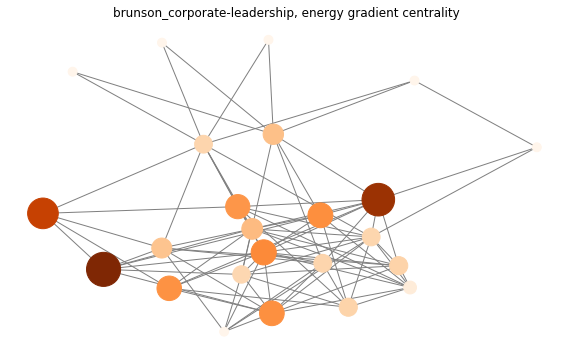

/data/anaconda/envs/entropy2/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


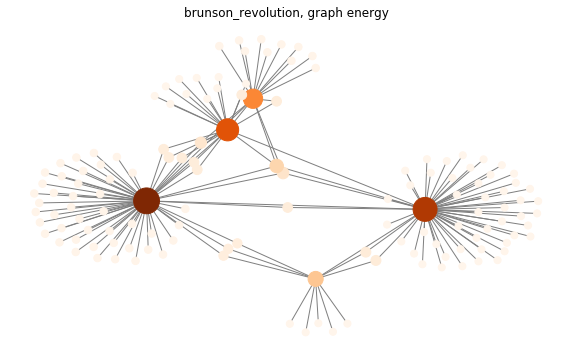

/data/anaconda/envs/entropy2/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


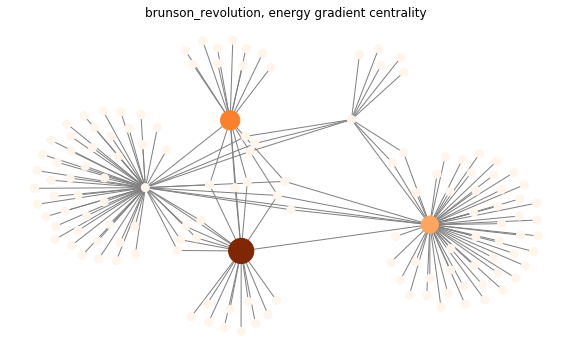

/data/anaconda/envs/entropy2/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


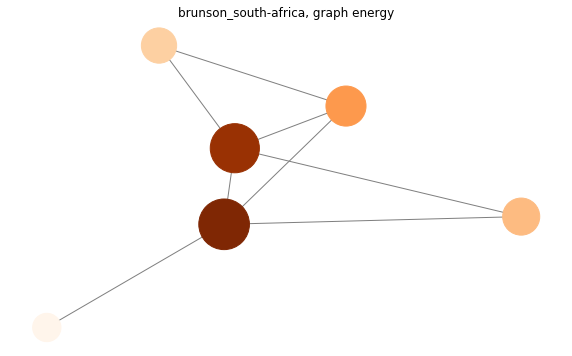

/data/anaconda/envs/entropy2/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


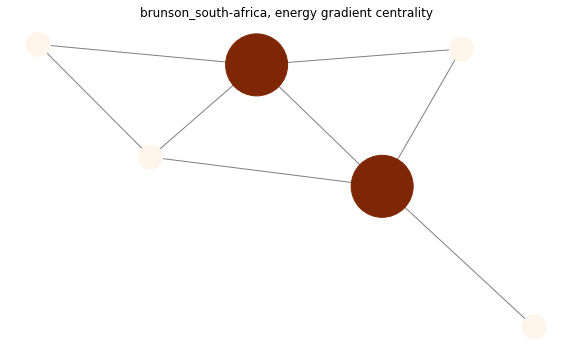

/data/anaconda/envs/entropy2/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


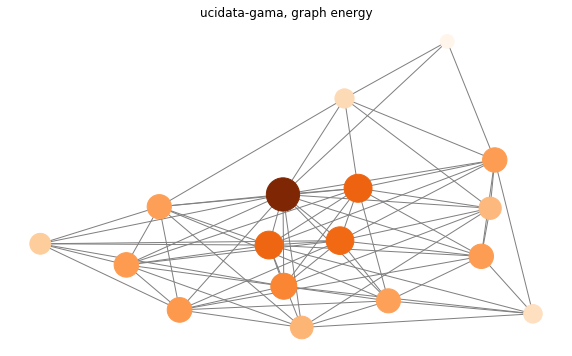

/data/anaconda/envs/entropy2/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


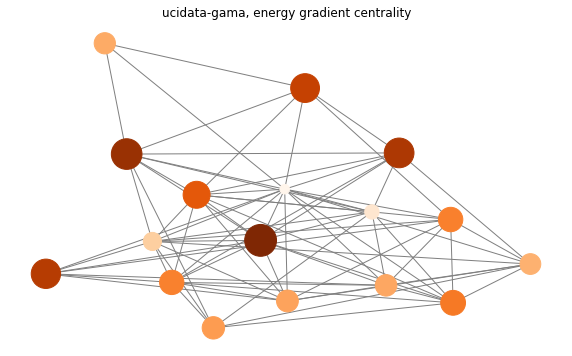

/data/anaconda/envs/entropy2/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


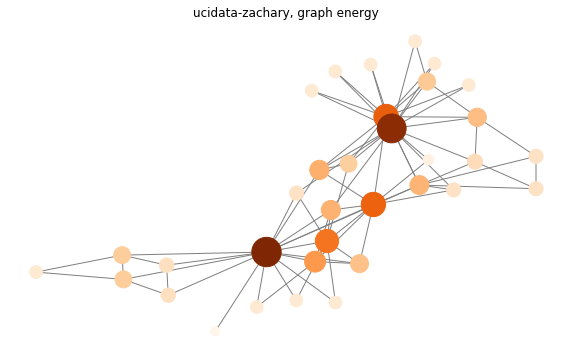

/data/anaconda/envs/entropy2/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


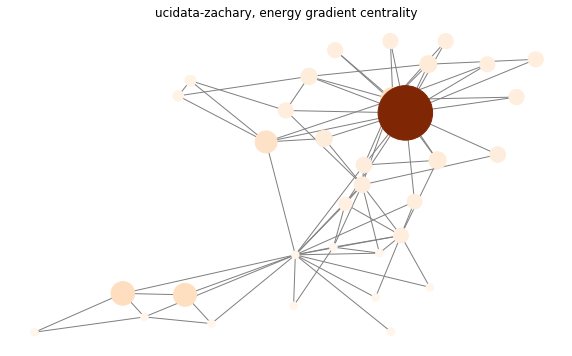

/data/anaconda/envs/entropy2/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


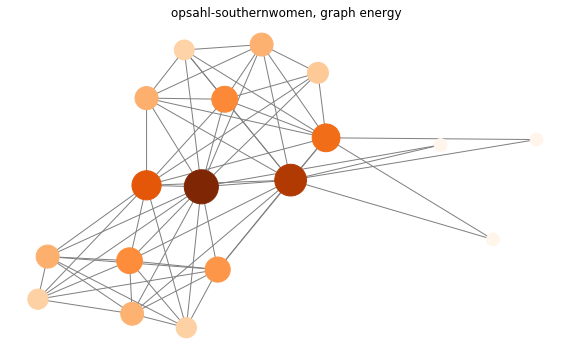

/data/anaconda/envs/entropy2/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


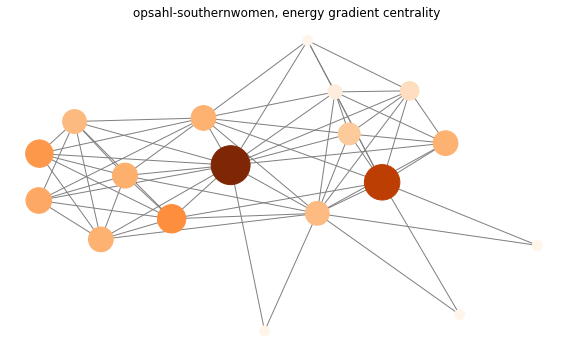

/data/anaconda/envs/entropy2/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


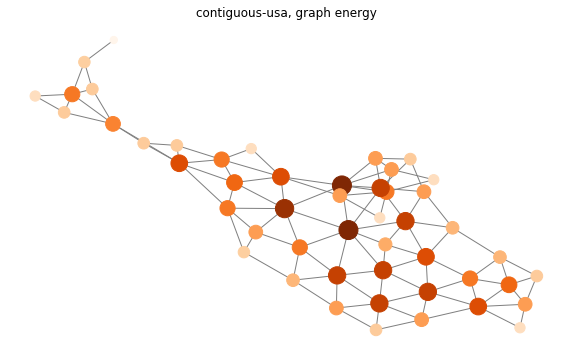

/data/anaconda/envs/entropy2/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


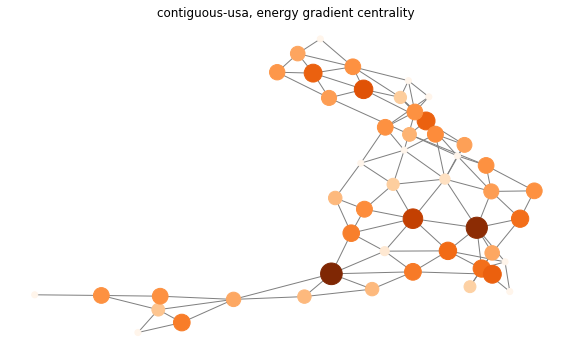

/data/anaconda/envs/entropy2/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


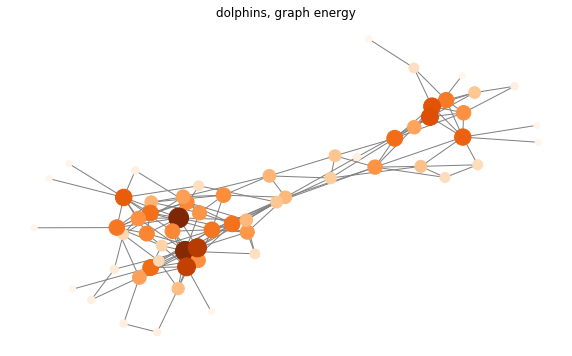

/data/anaconda/envs/entropy2/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


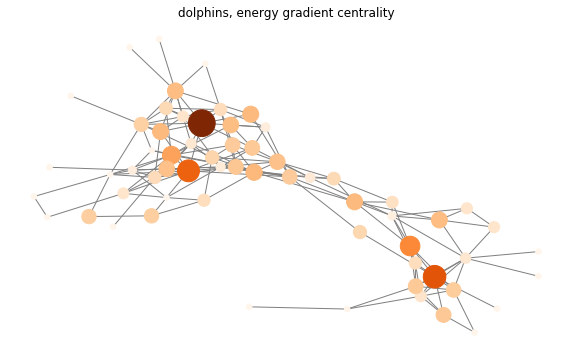

/data/anaconda/envs/entropy2/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


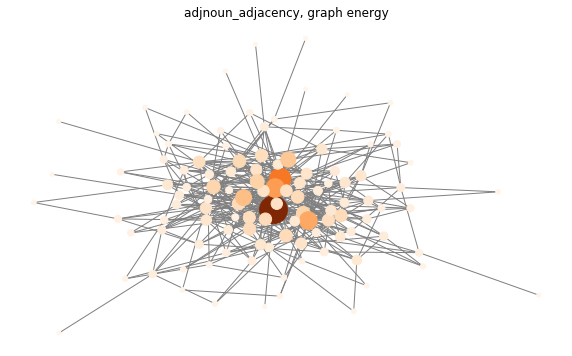

/data/anaconda/envs/entropy2/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


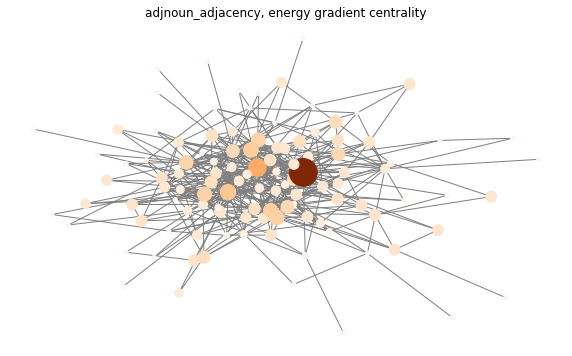

In [50]:
for i, (network_name, g) in tqdm(list(enumerate(small_networks))):
    display(HTML(f'<h2>{network_name}</h2>'))
    draw_graph(g, lambda g: normalize_dict(calculate_graph_energy(g)), title_postfix=', graph energy')
    draw_graph(g, lambda g: normalize_dict(calculate_graph_gradient_centrality(g)), title_postfix=', energy gradient centrality')
    
    dfs = []
    for repeat_no in tqdm(list(range(N_REPEATS))):
        results = run_network(g, BUDGET, ALLOCATIONS, NUM_ITERS)
        df = pd.DataFrame(list(map(lambda e: iteration_entry_to_dict(e, {'repeat_no': repeat_no}), results)))
        dfs.append(df)
    
    empirical_dfs.append(dfs)
    
        
# sns.set(rc={'figure.figsize':(11.7,8.27)})
# draw_inequalities(df)

In [51]:
with open(f"{RESULTS_PATH}empirical_dfs2.dat", "wb") as f:
    pickle.dump(empirical_dfs, f)

## Final minimal inequality

### Vertex distribution

In [91]:
import functools

In [92]:
empirical_df = pd.concat(empirical_dfs).reset_index()

In [103]:
empirical_df = empirical_df.query(f"allocation not in ['graph_gradnient_personalized', 'randic_gradnient_personalized']")

In [104]:
get_min_inequlity_method(empirical_df, 'vertex_distribution')

index                       network  iteration           allocation  \
197980   6580             adjnoun_adjacency        299             constant   
131994   6594       brunson_club-membership        299      graph_gradnient   
145192   6592  brunson_corporate-leadership        299     randic_gradnient   
151786   6586            brunson_revolution        299                graph   
158378   6578          brunson_south-africa        299               random   
138580   6580        brunson_southern-women        299             constant   
184786   6586                contiguous-usa        299                graph   
191386   6586                      dolphins        299                graph   
6578     6578                  moreno_beach        299               random   
13180    6580                  moreno_bison        299             constant   
19778    6578                 moreno_cattle        299               random   
26386    6586                  moreno_crime        299                graph   
32982    6582                   moreno_hens        299             pagerank   
39582    6582             moreno_highschool        299             pagerank   
46180    6580             moreno_innovation        299             constant   
52794    6594               moreno_kangaroo        299      graph_gradnient   
59380    6580                 moreno_lesmis        299             constant   
65978    6578                    moreno_mac        299               random   
72580    6580                     moreno_oz        299             constant   
79194    6594                 moreno_rhesus        299      graph_gradnient   
85780    6580                moreno_sampson        299             constant   
92390    6590                moreno_seventh        299  graph_gradnient_elu   
98980    6580                  moreno_sheep        299             constant   
105580   6580                   moreno_taro        299             constant   
112180   6580                  moreno_train        299             constant   
118780   6580                    moreno_vdb        299             constant   
125386   6586                  moreno_zebra        299                graph   
178180   6580          opsahl-southernwomen        299             constant   
164994   6594                  ucidata-gama        299      graph_gradnient   
171578   6578               ucidata-zachary        299               random   

           inequality_level  inequality  
197980  vertex_distribution    0.872375  
131994  vertex_distribution    0.785002  
145192  vertex_distribution    0.671012  
151786  vertex_distribution    0.895202  
158378  vertex_distribution    0.385136  
138580  vertex_distribution    0.262800  
184786  vertex_distribution    0.724648  
191386  vertex_distribution    0.792667  
6578    vertex_distribution    0.806848  
13180   vertex_distribution    0.540231  
19778   vertex_distribution    0.664493  
26386   vertex_distribution    0.648257  
32982   vertex_distribution    0.300688  
39582   vertex_distribution    0.943829  
46180   vertex_distribution    0.844051  
52794   vertex_distribution    0.653665  
59380   vertex_distribution    0.876260  
65978   vertex_distribution    0.732484  
72580   vertex_distribution    0.857963  
79194   vertex_distribution    0.577905  
85780   vertex_distribution    0.395300  
92390   vertex_distribution    0.663903  
98980   vertex_distribution    0.517143  
105580  vertex_distribution    0.750818  
112180  vertex_distribution    0.920844  
118780  vertex_distribution    0.588364  
125386  vertex_distribution    0.520292  
178180  vertex_distribution    0.756556  
164994  vertex_distribution    0.609803  
171578  vertex_distribution    0.894539

### Egocentric distribution

In [105]:
get_min_inequlity_method(empirical_df, 'egonet_distribution')

index                       network  iteration           allocation  \
197993   6593             adjnoun_adjacency        299     randic_gradnient   
131993   6593       brunson_club-membership        299     randic_gradnient   
145179   6579  brunson_corporate-leadership        299               random   
151793   6593            brunson_revolution        299     randic_gradnient   
158393   6593          brunson_south-africa        299     randic_gradnient   
138579   6579        brunson_southern-women        299               random   
184779   6579                contiguous-usa        299               random   
191379   6579                      dolphins        299               random   
6589     6589                  moreno_beach        299  randic_gradient_elu   
13189    6589                  moreno_bison        299  randic_gradient_elu   
19789    6589                 moreno_cattle        299  randic_gradient_elu   
26387    6587                  moreno_crime        299                graph   
32979    6579                   moreno_hens        299               random   
39581    6581             moreno_highschool        299             constant   
46179    6579             moreno_innovation        299               random   
52781    6581               moreno_kangaroo        299             constant   
59391    6591                 moreno_lesmis        299  graph_gradnient_elu   
65987    6587                    moreno_mac        299                graph   
72579    6579                     moreno_oz        299               random   
79181    6581                 moreno_rhesus        299             constant   
85789    6589                moreno_sampson        299  randic_gradient_elu   
92379    6579                moreno_seventh        299               random   
98991    6591                  moreno_sheep        299  graph_gradnient_elu   
105581   6581                   moreno_taro        299             constant   
112181   6581                  moreno_train        299             constant   
118791   6591                    moreno_vdb        299  graph_gradnient_elu   
125385   6585                  moreno_zebra        299               randic   
178193   6593          opsahl-southernwomen        299     randic_gradnient   
164979   6579                  ucidata-gama        299               random   
171581   6581               ucidata-zachary        299             constant   

           inequality_level  inequality  
197993  egonet_distribution    0.505351  
131993  egonet_distribution    0.147406  
145179  egonet_distribution    0.229397  
151793  egonet_distribution    0.215123  
158393  egonet_distribution    0.136867  
138579  egonet_distribution    0.043033  
184779  egonet_distribution    0.318334  
191379  egonet_distribution    0.413763  
6589    egonet_distribution    0.183305  
13189   egonet_distribution    0.066353  
19789   egonet_distribution    0.133794  
26387   egonet_distribution    0.773471  
32979   egonet_distribution    0.000000  
39581   egonet_distribution    0.078719  
46179   egonet_distribution    0.521287  
52781   egonet_distribution    0.208805  
59391   egonet_distribution    0.360084  
65987   egonet_distribution    0.080631  
72579   egonet_distribution    0.074646  
79181   egonet_distribution    0.291947  
85789   egonet_distribution    0.080514  
92379   egonet_distribution    0.043750  
98991   egonet_distribution    0.089207  
105581  egonet_distribution    0.179233  
112181  egonet_distribution    0.320737  
118791  egonet_distribution    0.085273  
125385  egonet_distribution    0.267903  
178193  egonet_distribution    0.133299  
164979  egonet_distribution    0.131733  
171581  egonet_distribution    0.213590

In [106]:
avg_roc_df = group_and_calculate_avg_roc_and_variance(empirical_df)

## Rate of Change 

### Vertex distribution

Intrestingly, we can see that gradient alocation methods often have the lowest average rate of change of inequality over iterations

In [108]:
get_min_statistic_method(avg_roc_df, 'avg_roc', 'vertex_distribution')

avg_roc
network                      allocation          inequality_level               
adjnoun_adjacency            graph_gradnient_elu vertex_distribution 0  0.001266
brunson_club-membership      graph_gradnient     vertex_distribution 0  0.001102
brunson_corporate-leadership graph_gradnient     vertex_distribution 0  0.000927
brunson_revolution           randic_gradient_elu vertex_distribution 0  0.000940
brunson_south-africa         random              vertex_distribution 0  0.000213
brunson_southern-women       random              vertex_distribution 0  0.000325
contiguous-usa               randic_gradnient    vertex_distribution 0  0.001280
dolphins                     graph_gradnient     vertex_distribution 0  0.001315
moreno_beach                 random              vertex_distribution 0  0.001266
moreno_bison                 randic_gradnient    vertex_distribution 0  0.000718
moreno_cattle                random              vertex_distribution 0  0.001018
moreno_crime                 randic_gradient_elu vertex_distribution 0  0.000345
moreno_hens                  random              vertex_distribution 0  0.000158
moreno_highschool            randic_gradient_elu vertex_distribution 0  0.001914
moreno_innovation            graph_gradnient     vertex_distribution 0  0.001415
moreno_kangaroo              graph_gradnient     vertex_distribution 0  0.000511
moreno_lesmis                graph_gradnient_elu vertex_distribution 0  0.001118
moreno_mac                   random              vertex_distribution 0  0.001385
moreno_oz                    graph_gradnient_elu vertex_distribution 0  0.001325
moreno_rhesus                graph_gradnient     vertex_distribution 0  0.000378
moreno_sampson               graph_gradnient     vertex_distribution 0  0.000190
moreno_seventh               random              vertex_distribution 0  0.001394
moreno_sheep                 graph_gradnient     vertex_distribution 0  0.000661
moreno_taro                  randic_gradnient    vertex_distribution 0  0.001466
moreno_train                 graph_gradnient_elu vertex_distribution 0  0.001479
moreno_vdb                   random              vertex_distribution 0  0.000801
moreno_zebra                 graph_gradnient     vertex_distribution 0  0.000440
opsahl-southernwomen         random              vertex_distribution 0  0.001261
ucidata-gama                 random              vertex_distribution 0  0.001151
ucidata-zachary              graph_gradnient     vertex_distribution 0  0.001345

### Egocentric distribution

In [109]:
get_min_statistic_method(avg_roc_df, 'avg_roc', 'egonet_distribution')

avg_roc
network                      allocation          inequality_level               
adjnoun_adjacency            randic_gradient_elu egonet_distribution 0  0.000285
brunson_club-membership      graph_gradnient     egonet_distribution 0 -0.000344
brunson_corporate-leadership randic_gradnient    egonet_distribution 0  0.000036
brunson_revolution           random              egonet_distribution 0 -0.000203
brunson_south-africa         random              egonet_distribution 0 -0.000132
brunson_southern-women       constant            egonet_distribution 0 -0.000114
contiguous-usa               random              egonet_distribution 0  0.000399
dolphins                     randic_gradient_elu egonet_distribution 0  0.000277
moreno_beach                 random              egonet_distribution 0 -0.000266
moreno_bison                 graph_gradnient     egonet_distribution 0 -0.000201
moreno_cattle                random              egonet_distribution 0 -0.000150
moreno_crime                 randic_gradient_elu egonet_distribution 0  0.000705
moreno_hens                  constant            egonet_distribution 0  0.000000
moreno_highschool            randic_gradnient    egonet_distribution 0 -0.000806
moreno_innovation            randic_gradnient    egonet_distribution 0  0.000731
moreno_kangaroo              constant            egonet_distribution 0 -0.000326
moreno_lesmis                graph_gradnient     egonet_distribution 0 -0.000180
moreno_mac                   graph_gradnient     egonet_distribution 0 -0.000106
moreno_oz                    graph_gradnient     egonet_distribution 0 -0.000719
moreno_rhesus                graph_gradnient     egonet_distribution 0 -0.000077
moreno_sampson               graph_gradnient     egonet_distribution 0 -0.000061
moreno_seventh               constant            egonet_distribution 0 -0.000320
moreno_sheep                 graph_gradnient     egonet_distribution 0 -0.000055
moreno_taro                  randic_gradnient    egonet_distribution 0  0.000091
moreno_train                 graph_gradnient     egonet_distribution 0 -0.000373
moreno_vdb                   randic_gradnient    egonet_distribution 0 -0.000177
moreno_zebra                 graph_gradnient     egonet_distribution 0  0.000078
opsahl-southernwomen         constant            egonet_distribution 0 -0.000254
ucidata-gama                 randic_gradnient    egonet_distribution 0 -0.000023
ucidata-zachary              random              egonet_distribution 0 -0.000391

## Variance

### Vertex distribution

Intrestingly, we can see that gradient methods often have the lowest variance of inequality over iterations

In [110]:
get_min_statistic_method(avg_roc_df, 'variance', 'vertex_distribution')

variance
network                      allocation          inequality_level               
adjnoun_adjacency            randic_gradient_elu vertex_distribution 0  0.003658
brunson_club-membership      graph_gradnient     vertex_distribution 0  0.007439
brunson_corporate-leadership graph_gradnient     vertex_distribution 0  0.007163
brunson_revolution           randic_gradient_elu vertex_distribution 0  0.000342
brunson_south-africa         random              vertex_distribution 0  0.000970
brunson_southern-women       random              vertex_distribution 0  0.000670
contiguous-usa               randic_gradnient    vertex_distribution 0  0.010528
dolphins                     graph_gradnient_elu vertex_distribution 0  0.006778
moreno_beach                 random              vertex_distribution 0  0.011178
moreno_bison                 randic_gradnient    vertex_distribution 0  0.005471
moreno_cattle                random              vertex_distribution 0  0.009036
moreno_crime                 randic_gradient_elu vertex_distribution 0  0.000300
moreno_hens                  random              vertex_distribution 0  0.001168
moreno_highschool            randic_gradient_elu vertex_distribution 0  0.009965
moreno_innovation            graph_gradnient     vertex_distribution 0  0.006452
moreno_kangaroo              graph_gradnient     vertex_distribution 0  0.001078
moreno_lesmis                graph_gradnient_elu vertex_distribution 0  0.003033
moreno_mac                   randic_gradnient    vertex_distribution 0  0.012786
moreno_oz                    randic_gradient_elu vertex_distribution 0  0.002581
moreno_rhesus                graph_gradnient     vertex_distribution 0  0.000596
moreno_sampson               graph_gradnient     vertex_distribution 0  0.000367
moreno_seventh               randic_gradnient    vertex_distribution 0  0.011467
moreno_sheep                 randic_gradnient    vertex_distribution 0  0.004682
moreno_taro                  randic_gradnient    vertex_distribution 0  0.017128
moreno_train                 randic_gradient_elu vertex_distribution 0  0.006886
moreno_vdb                   random              vertex_distribution 0  0.004974
moreno_zebra                 randic_gradnient    vertex_distribution 0  0.001199
opsahl-southernwomen         random              vertex_distribution 0  0.011663
ucidata-gama                 random              vertex_distribution 0  0.012950
ucidata-zachary              graph_gradnient     vertex_distribution 0  0.005943

### Egocentric distribution

In [111]:
get_min_statistic_method(avg_roc_df, 'variance', 'egonet_distribution')

variance
network                      allocation          inequality_level               
adjnoun_adjacency            randic_gradient_elu egonet_distribution 0  0.000579
brunson_club-membership      randic_gradient_elu egonet_distribution 0  0.000037
brunson_corporate-leadership randic_gradnient    egonet_distribution 0  0.000058
brunson_revolution           randic_gradnient    egonet_distribution 0  0.000014
brunson_south-africa         graph_gradnient     egonet_distribution 0  0.000004
brunson_southern-women       random              egonet_distribution 0  0.000024
contiguous-usa               graph               egonet_distribution 0  0.001165
dolphins                     randic_gradient_elu egonet_distribution 0  0.000489
moreno_beach                 randic              egonet_distribution 0  0.000081
moreno_bison                 graph               egonet_distribution 0  0.000086
moreno_cattle                randic_gradnient    egonet_distribution 0  0.000061
moreno_crime                 randic_gradient_elu egonet_distribution 0  0.002939
moreno_hens                  constant            egonet_distribution 0  0.000000
moreno_highschool            randic_gradient_elu egonet_distribution 0  0.000279
moreno_innovation            randic_gradnient    egonet_distribution 0  0.004370
moreno_kangaroo              pagerank            egonet_distribution 0  0.000295
moreno_lesmis                randic_gradient_elu egonet_distribution 0  0.000003
moreno_mac                   graph               egonet_distribution 0  0.000023
moreno_oz                    graph               egonet_distribution 0  0.000283
moreno_rhesus                randic              egonet_distribution 0  0.000009
moreno_sampson               randic_gradnient    egonet_distribution 0  0.000002
moreno_seventh               graph               egonet_distribution 0  0.000379
moreno_sheep                 randic              egonet_distribution 0  0.000001
moreno_taro                  randic_gradnient    egonet_distribution 0  0.000136
moreno_train                 randic              egonet_distribution 0  0.000056
moreno_vdb                   graph               egonet_distribution 0  0.000066
moreno_zebra                 randic_gradnient    egonet_distribution 0  0.000093
opsahl-southernwomen         randic              egonet_distribution 0  0.000134
ucidata-gama                 randic              egonet_distribution 0  0.000002
ucidata-zachary              randic_gradient_elu egonet_distribution 0  0.000008

In [50]:
import requests

def download_file_from_google_drive(id, destination):
    URL = "https://docs.google.com/uc?export=download"

    session = requests.Session()

    response = session.get(URL, params = { 'id' : id }, stream = True)
    token = get_confirm_token(response)

    if token:
        params = { 'id' : id, 'confirm' : token }
        response = session.get(URL, params = params, stream = True)

    save_response_content(response, destination)    

def get_confirm_token(response):
    for key, value in response.cookies.items():
        if key.startswith('download_warning'):
            return value

    return None

def save_response_content(response, destination):
    CHUNK_SIZE = 32768

    with open(destination, "wb") as f:
        for chunk in response.iter_content(CHUNK_SIZE):
            if chunk: # filter out keep-alive new chunks
                f.write(chunk)

In [51]:
download_file_from_google_drive("1KXBEVM0_hECb6epGvPKahiPMO8tF8iUh", "data_downalod.zip")

In [54]:
import zipfile
zip_ref = zipfile.ZipFile("data_downalod.zip", 'r')
zip_ref.extractall(".")
zip_ref.close()